<a href="https://colab.research.google.com/github/deniseiras/BAM1D-Microphysics-Emulation/blob/main/BAM1D_Physics_Emulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAM1D Physics Emulation

<font size="5">**Objetivo:** Emular a Hugh Morrison Microphysics implementada em BAM1D</font>
 


SUBROUTINE RunMicro_HugMorr(  
  
**ncols** - numero de colunas - fixo = 1  
nCols       , &!INTEGER      , INTENT(IN   ) :: nCols

**kmax** - número de níveis = k_max  
kMax        , &!INTEGER      , INTENT(IN   ) :: kMax 

**si** - kmax+1 removido, sem valores/usado
si          , &!REAL(KIND=r8), INTENT(IN   ) :: si(kMax+1)

**sl**  
sl          , &!REAL(KIND=r8), INTENT(IN   ) :: sl(kMax)

**tc** - Temperature(K)  
tc          , &!REAL(KIND=r8), INTENT(INOUT) :: Tc (1:nCols, 1:kMax)

<font size="5">Q's - Mixing ratio </font>

**QV** - water vapor  
QV          , &!REAL(KIND=r8), INTENT(INOUT) :: qv (1:nCols, 1:kMax)

**QC** - cloud water  
QC          , &!REAL(KIND=r8), INTENT(INOUT) :: qc (1:nCols, 1:kMax)

**QR**  - rain water  
QR          , &!REAL(KIND=r8), INTENT(INOUT) :: qr (1:nCols, 1:kMax)

**QI** - cloud ice  
QI          , &!REAL(KIND=r8), INTENT(INOUT) :: qi (1:nCols, 1:kMax)

**QS** - Snow  
QS          , &!REAL(KIND=r8), INTENT(INOUT) :: qs (1:nCols, 1:kMax)

**QG** - Graupel  
QG          , &!REAL(KIND=r8), INTENT(INOUT) :: qg (1:nCols, 1:kMax)

<font size="5">*N's* - number concentration
</font>  

**NI** - cloud ice  
NI          , &!REAL(KIND=r8), INTENT(INOUT) :: ni (1:nCols, 1:kMax)

**NS** - Snow  
NS          , &!REAL(KIND=r8), INTENT(INOUT) :: ns (1:nCols, 1:kMax)

**NR** - Rain    
NR          , &!REAL(KIND=r8), INTENT(INOUT) :: nr (1:nCols, 1:kMax)

**NG** - Graupel  
NG          , &!REAL(KIND=r8), INTENT(INOUT) :: NG (1:nCols, 1:kMax)   

**NC** - Cloud droplet  
NC          , &!REAL(KIND=r8), INTENT(INOUT) :: NC (1:nCols, 1:kMax)   

**TKE** - turbulence kinetic energy (m^2 s-2), NEEDED FOR DROPLET ACTIVATION  
TKE         , &!REAL(KIND=r8), INTENT(IN   ) :: TKE (1:nCols, 1:kMax)   

**KZH** -  heat eddy diffusion coefficient from YSU scheme (M^2 S-1), NEEDED FOR DROPLET ACTIVATION  
KZH         , &!REAL(KIND=r8), INTENT(IN   ) :: KZH (1:nCols, 1:kMax)   

**gps** - Pressão - removida da entrada da RNA - valor fixo  
gps         , &!gps- AIR PRESSURE (PA)

**DT_IN** - model time step (sec) - Removido da entrada da RNA
DT_IN       , &!REAL(KIND=r8), INTENT(IN   ) :: dt_in

**omega**  
omega       , &!REAL(KIND=r8), INTENT(IN   ) :: omega  ! omega (Pa/s)

**EFFCS** - CLOUD DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFCS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFCS (1:nCols, 1:kMax)   

**EFFIS** - ICE DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFIS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFIS (1:nCols, 1:kMax)   

**LSRAIN** - Large scale Rain  
LSRAIN      , &!REAL(KIND=r8), INTENT(OUT) :: LSRAIN(1:nCols)

**LSSNOW** - Large scale Snow  
LSSNOW        )!REAL(KIND=r8), INTENT(OUT) :: LSSNOW(1:nCols)


# Setup do dados

Carregamento dos dados

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from sklearn import metrics

# %tensorflow_version 1.x

import tensorflow as tf
import keras
from tensorflow.python.data import Dataset

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
import csv    

from datetime import datetime
from shutil import copyfile, copytree, rmtree

k_max = 28  # número de níveis utilizado

# % pip install XlsxWriter
# % pip install SkillMetrics
# import skill_metrics as sm


# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.1f}'.format
pd.options.display.float_format = '{:f}'.format


# working local
#
# %load_ext tensorboard funciona local ???
# %reload_ext tensorboard ???

colab_in_drive_root_dir = "/home/denis/_COM_BACKUP/NN_BAM1d/bam1d_data/Colab Notebooks"
tb_logdir_base = colab_in_drive_root_dir + '/logs'

# loading from gdrive - COLAB MOUNTS AUTOMATICALLY NOW
# from google.colab import drive
# drive.mount('/content/drive') # , force_remount=True

# tb_logdir_base = './logs'

data_in_drive_dir = "/media/denis/dados/_COM_BACKUP/NN_BAM1D/bam1d_data/"
# colab_in_drive_root_dir = "/content/drive/My Drive/Colab Notebooks/"
# data_in_drive_dir = "/content/drive/My Drive/NN_Microphysics/"

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_RRTMG.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_RRTMG.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_HSR.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_HSR.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_RRTMG___dt_60.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_RRTMG___dt_60.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}/IOP2014__CRD_RRTMG_dt_360/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/IOP2014__CRD_RRTMG_dt_360/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

original_input_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_60/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
original_output_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_60/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")



## Análise dos dados

### Análise estatística

- Resumo dos valores das variáveis de entrada e saída. Observe que os valores são truncados no Resumo
- Valores do primeiro, centésimo e último passo de tempo
- Níveis verticais do primeiro, centésimo e último passo de tempo

In [2]:
print("\nAll input summary:")
display.display(original_input_df.describe())
print("\nAll output summary:")
display.display(original_output_df.describe())

print("\nInput First timestep:")
display.display(original_input_df.head(k_max))
print("\nInput 100th timestep:")
display.display(original_input_df.loc[k_max*100:k_max*100+27])
print("\nInput Last timestep:")
display.display(original_input_df.tail(k_max))

print("\nOutput First timestep:")
display.display(original_output_df.head(k_max))
print("\nOutput 100th timestep:")
display.display(original_output_df.loc[k_max*100:k_max*100+27])
print("\nOutput Last timestep:")
display.display(original_output_df.tail(k_max))

# original_output_df.describe().to_csv('/content/drive/My Drive/Colab Notebooks/temp_describe.csv')




All input summary:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
count,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000
mean,14.500000,0.468551,0.000000,0.450519,237.810254,0.005165,0.000001,0.000002,0.000000,0.000025,0.000000,525.343390,73371.650376,3421.866932,0.008298,121085.882071,0.492773,44.724548,99000.000000,-0.011697
std,8.077747,0.363560,0.000000,0.361058,61.403796,0.005987,0.000014,0.000016,0.000002,0.000083,0.000001,17428.285154,320428.431238,38701.308990,0.974857,969837.242680,1.391556,87.193590,0.000000,0.079013
min,1.000000,0.003669,0.000000,0.001523,62.841959,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,99000.000000,-1.076957
25%,7.750000,0.103880,0.000000,0.090635,203.013223,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.023810
50%,14.500000,0.432240,0.000000,0.399916,257.597808,0.001706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
75%,21.250000,0.834470,0.000000,0.811268,288.967070,0.010225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.590780,0.000000,0.000000,0.000000,0.000000,40.887460,99000.000000,0.015080
max,28.000000,1.000000,0.000000,0.994964,309.060025,0.016230,0.000406,0.000679,0.000231,0.001540,0.000548,1145097.162600,2947550.902120,1203670.877910,690.523505,37415340.091400,6.000000,300.000000,99000.000000,0.535213



All output summary:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
count,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000,14595868.000000
mean,14.500000,237.810344,0.005165,0.000001,0.000002,0.000000,0.000025,0.000000,525.343390,73371.764992,3421.867930,0.008298,121086.394522,24.674676,25.970272,0.000000,0.000000
std,8.077747,61.403347,0.005988,0.000014,0.000016,0.000002,0.000083,0.000001,17428.285154,320428.449518,38701.309002,0.974857,969838.903328,2.347809,8.828024,0.000001,0.000000
min,1.000000,62.841959,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
25%,7.750000,203.013223,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
50%,14.500000,257.623739,0.001717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
75%,21.250000,288.966639,0.010232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.591107,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
max,28.000000,309.060025,0.016244,0.000406,0.000679,0.000231,0.001540,0.000548,1145097.162600,2947550.902120,1203670.877910,690.523505,37415340.091400,25.000000,130.000000,0.000028,0.000000



Input First timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
0,1,1.000000,0.000000,0.994964,300.677774,0.016230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063127,99000.000000,-0.012614
1,2,0.989934,0.000000,0.981964,300.528179,0.015747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152506,99000.000000,-0.001955
2,3,0.974009,0.000000,0.964137,299.964607,0.015145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.028920
3,4,0.954290,0.000000,0.942167,298.656488,0.014704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.037237
4,5,0.930081,0.000000,0.915361,296.810848,0.014252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.033169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,24,0.042912,0.000000,0.035429,201.422018,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
24,25,0.028306,0.000000,0.022285,207.618421,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
25,26,0.016629,0.000000,0.011763,211.541417,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
26,27,0.007338,0.000000,0.005429,214.013529,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000



Input 100th timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
2800,1,1.000000,0.000000,0.994964,302.459534,0.016230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.634578,99000.000000,-0.005869
2801,2,0.989934,0.000000,0.981964,301.239494,0.015747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065609,8.884557,99000.000000,-0.014401
2802,3,0.974009,0.000000,0.964137,299.621827,0.015145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111963,1.653756,99000.000000,-0.017420
2803,4,0.954290,0.000000,0.942167,298.134956,0.014704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826878,99000.000000,-0.013887
2804,5,0.930081,0.000000,0.915361,296.253971,0.014252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,-0.002427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,24,0.042912,0.000000,0.035429,200.674253,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
2824,25,0.028306,0.000000,0.022285,206.718617,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
2825,26,0.016629,0.000000,0.011763,209.737962,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
2826,27,0.007338,0.000000,0.005429,212.119083,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000



Input Last timestep:


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
14595840,1,1.000000,0.000000,0.994964,303.504914,0.016230,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,23.380929,0.000000,0.000000,0.000000,25.872320,99000.000000,0.000416
14595841,2,0.989934,0.000000,0.981964,302.447406,0.015747,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,28.182750,0.000000,0.000000,0.084519,53.076727,99000.000000,0.004870
14595842,3,0.974009,0.000000,0.964137,300.968848,0.015145,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,37.651762,0.000000,0.000000,0.439311,50.412554,99000.000000,0.011449
14595843,4,0.954290,0.000000,0.942167,299.075814,0.014704,0.000000,0.000013,0.000000,0.000000,0.000000,0.000000,0.000000,53.851476,0.000000,0.000000,0.334611,60.704847,99000.000000,0.017780
14595844,5,0.930081,0.000000,0.915361,296.700526,0.014252,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,82.278735,0.000000,0.000000,0.892645,62.248870,99000.000000,0.022871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14595863,24,0.042912,0.000000,0.035429,181.170340,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,99000.000000,0.000000
14595864,25,0.028306,0.000000,0.022285,159.062852,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.223596,99000.000000,0.000000
14595865,26,0.016629,0.000000,0.011763,132.552622,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.463488,148.447192,99000.000000,0.000000
14595866,27,0.007338,0.000000,0.005429,110.065204,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.000000,99000.000000,0.000000



Output First timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
0,1,300.677774,0.016230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
1,2,300.528179,0.015747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
2,3,299.964607,0.015145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
3,4,298.656488,0.014704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
4,5,296.810848,0.014252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,24,201.422018,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
24,25,207.618421,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
25,26,211.541417,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
26,27,214.013529,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000



Output 100th timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
2800,1,302.459534,0.016230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
2801,2,301.239494,0.015747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
2802,3,299.621827,0.015145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
2803,4,298.134956,0.014704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
2804,5,296.253971,0.014252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,24,200.674253,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
2824,25,206.718617,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
2825,26,209.737962,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000
2826,27,212.119083,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000



Output Last timestep:


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
14595840,1,303.501381,0.016231,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,23.371391,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
14595841,2,302.443579,0.015749,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,28.173337,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
14595842,3,300.964520,0.015147,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,37.643860,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
14595843,4,299.071008,0.014706,0.000000,0.000013,0.000000,0.000000,0.000000,0.000000,0.000000,53.849192,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
14595844,5,296.695381,0.014254,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,82.291518,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14595863,24,181.170340,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
14595864,25,159.062852,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
14595865,26,132.552622,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000
14595866,27,110.065204,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000001,0.000000


### Histogramas das variáveis de entrada

In [3]:
# Input Histograms

# _ = original_input_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)

### Histogramas das variáveis de saída

In [4]:
# Output Histograms

# _ = original_output_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)
#_ = validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

### Bloxpot das variáveis de entrada por níveis

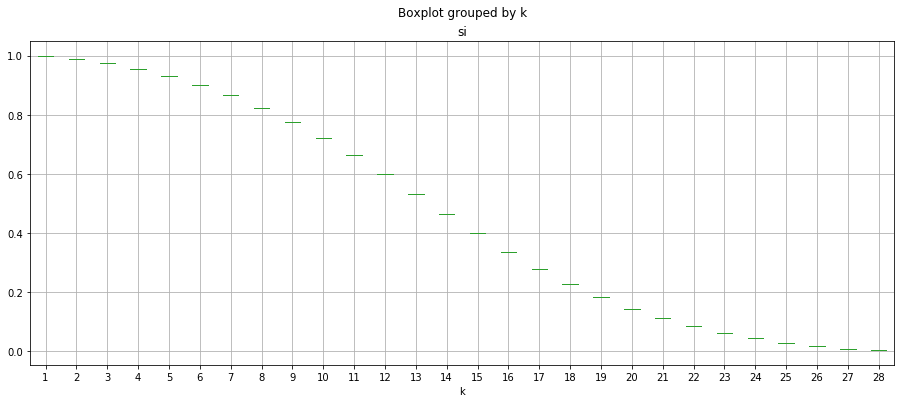

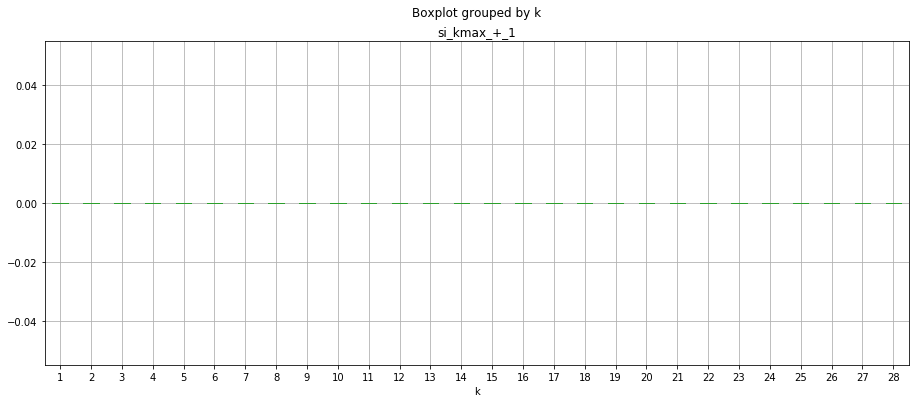

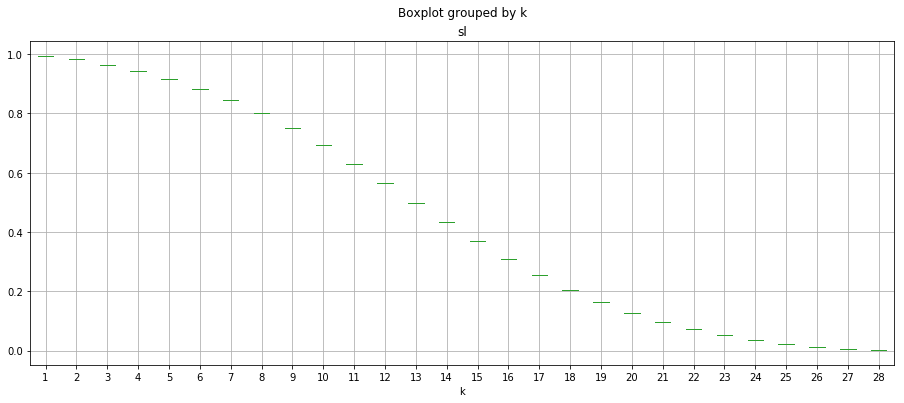

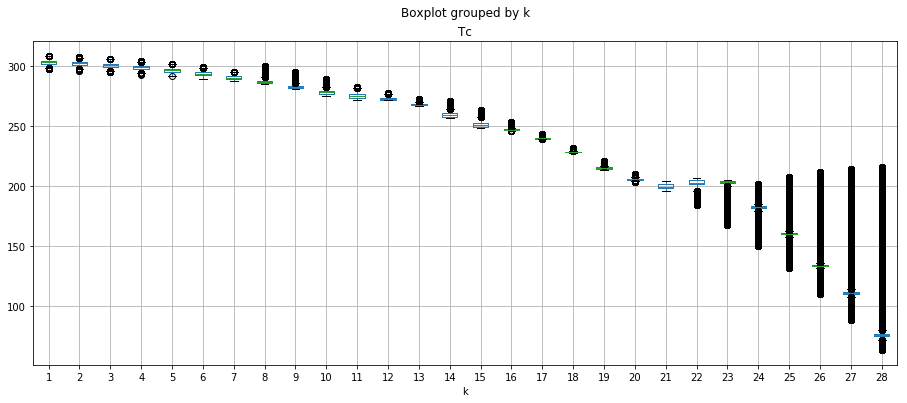

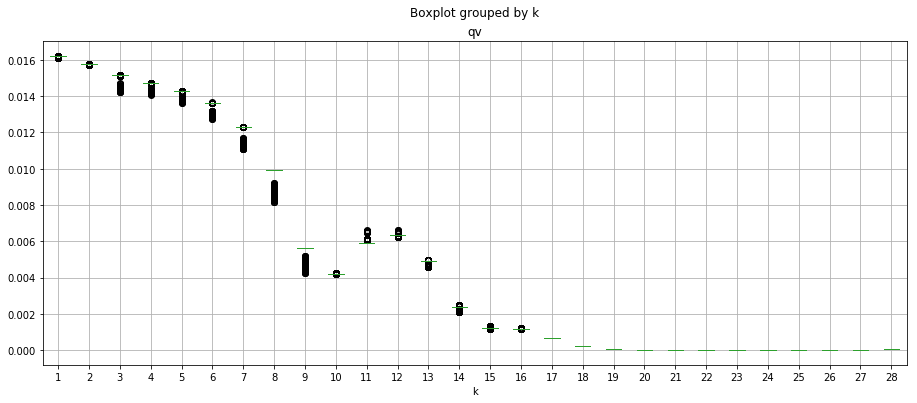

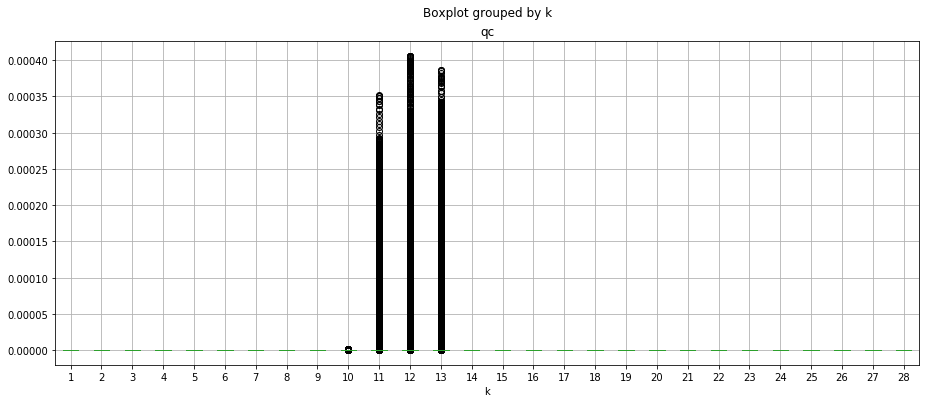

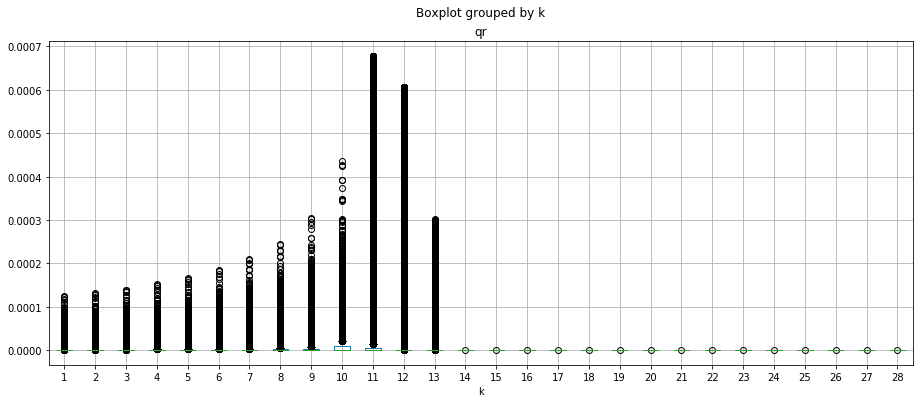

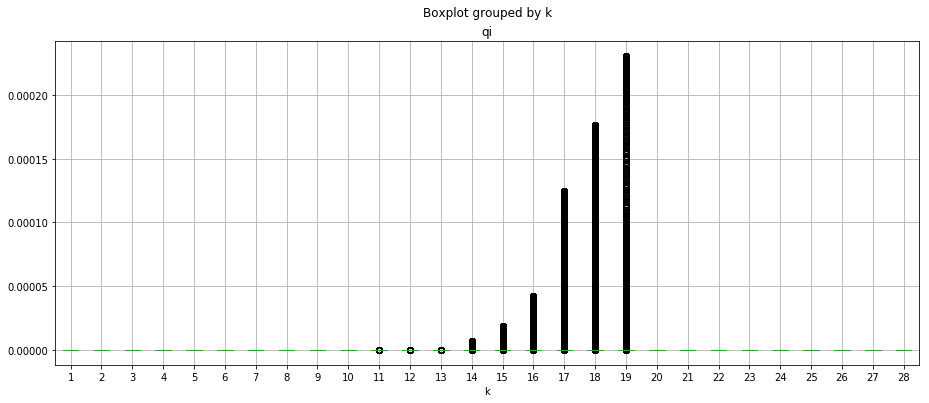

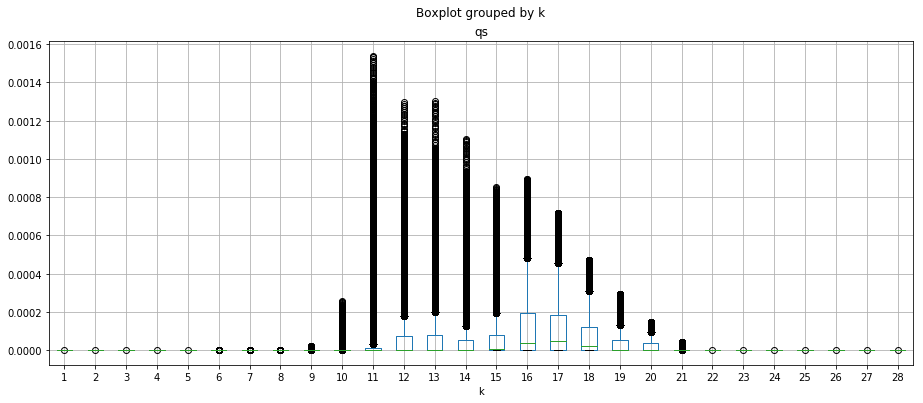

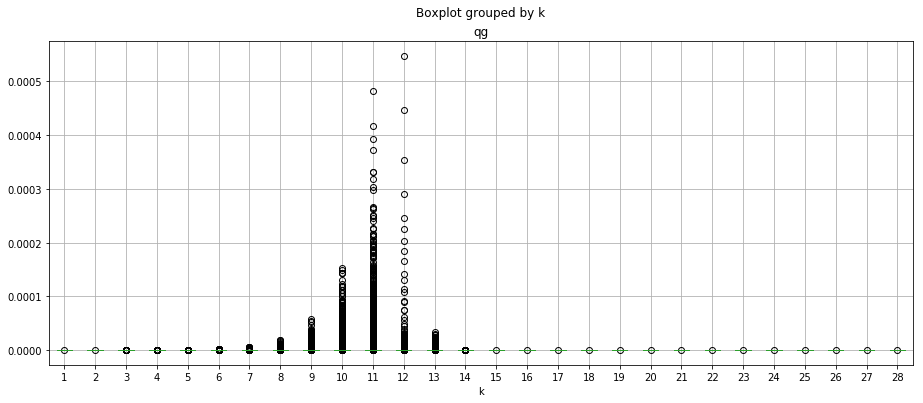

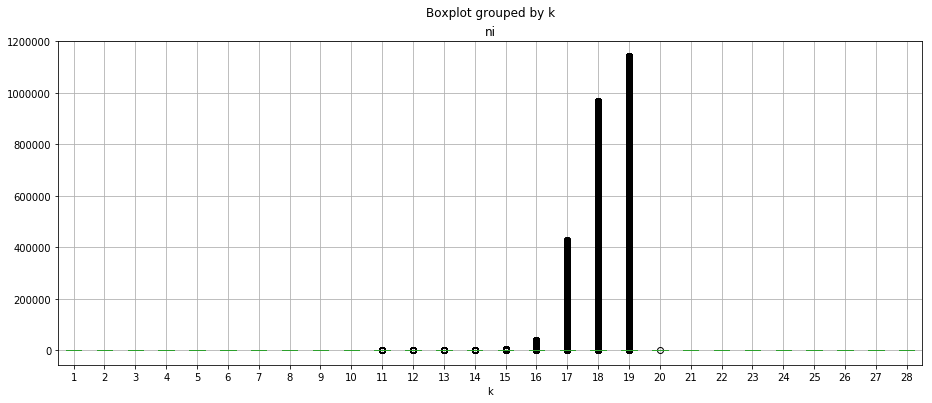

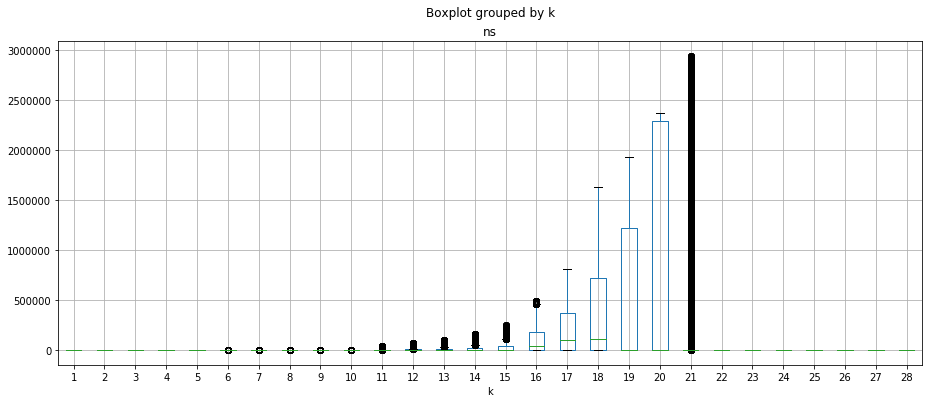

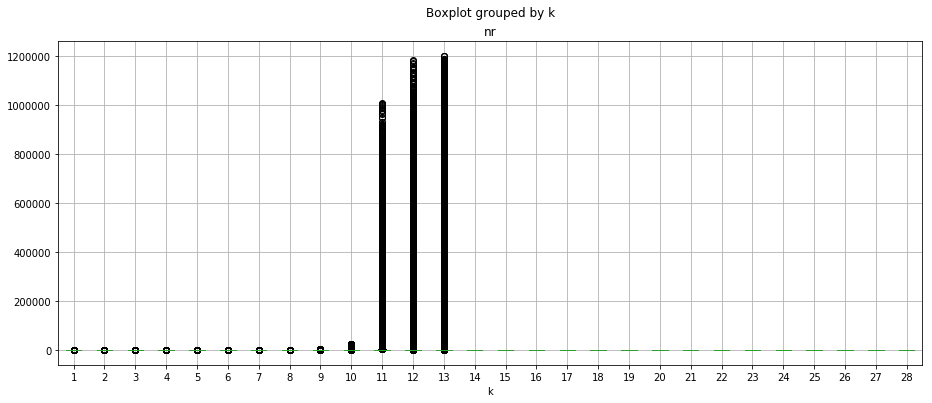

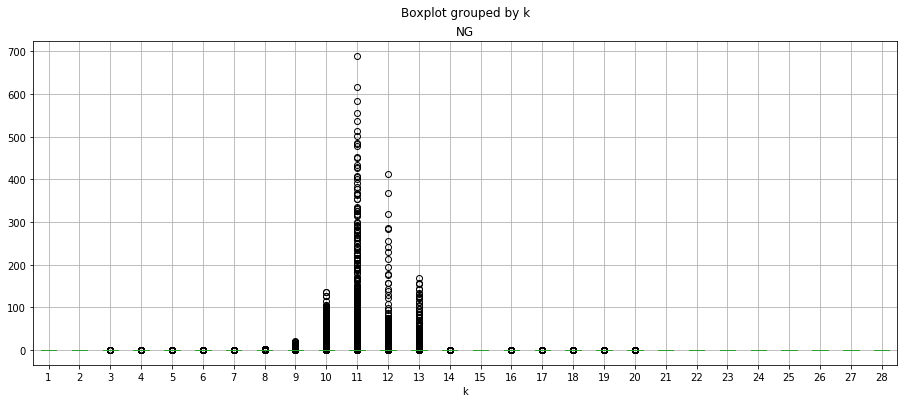

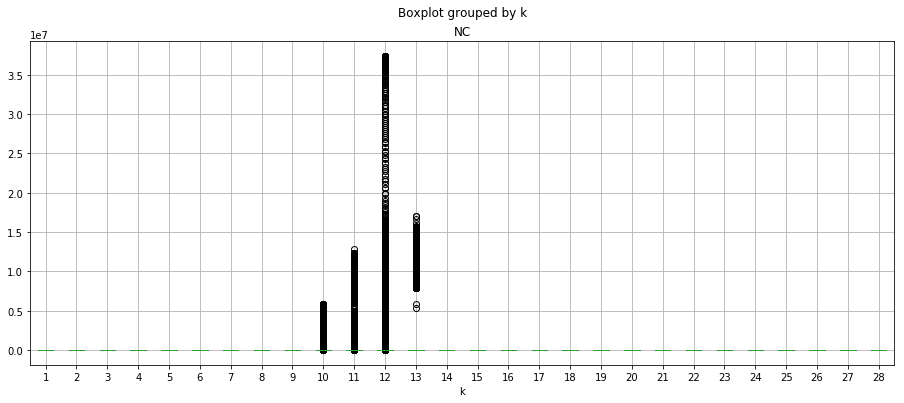

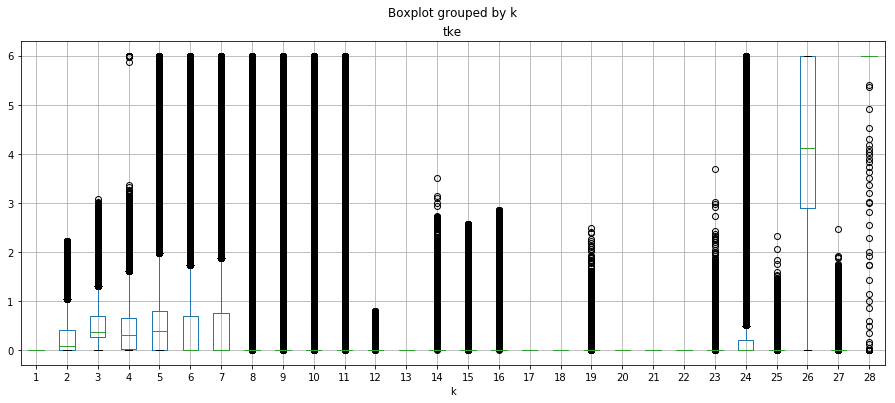

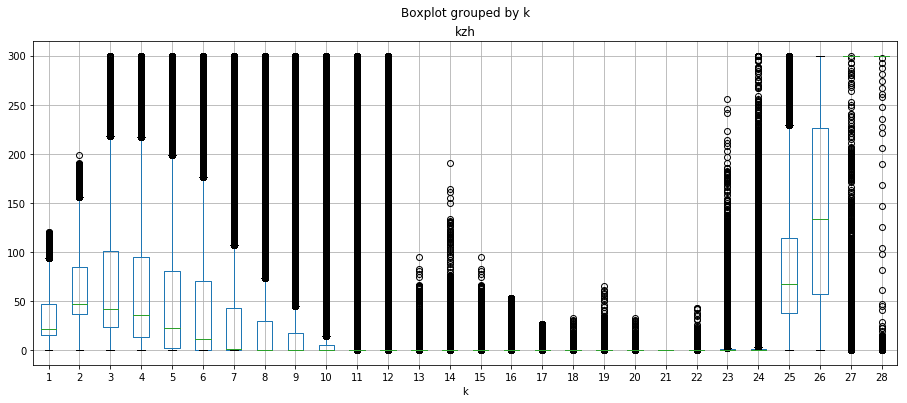

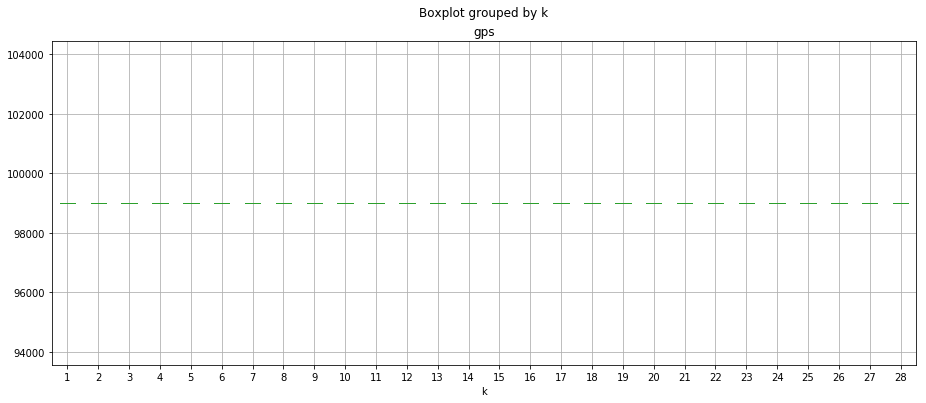

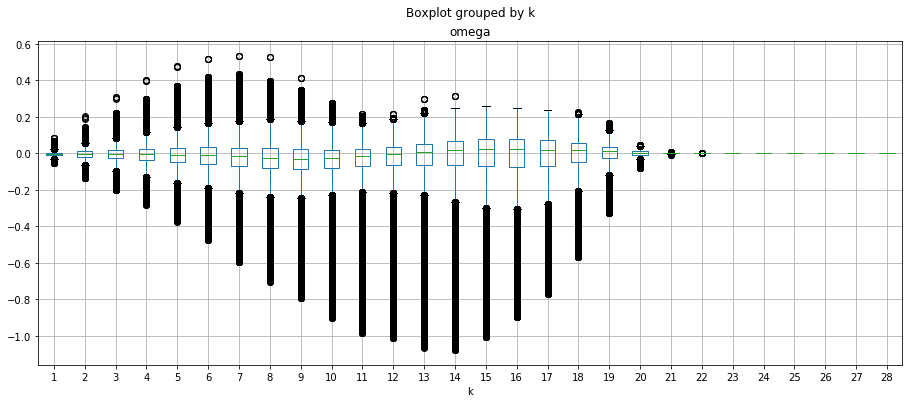

In [5]:
# Boxplot of variables through levels

for key in original_input_df.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    original_input_df.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()


### Boxplot das variáveis de saída, por níveis

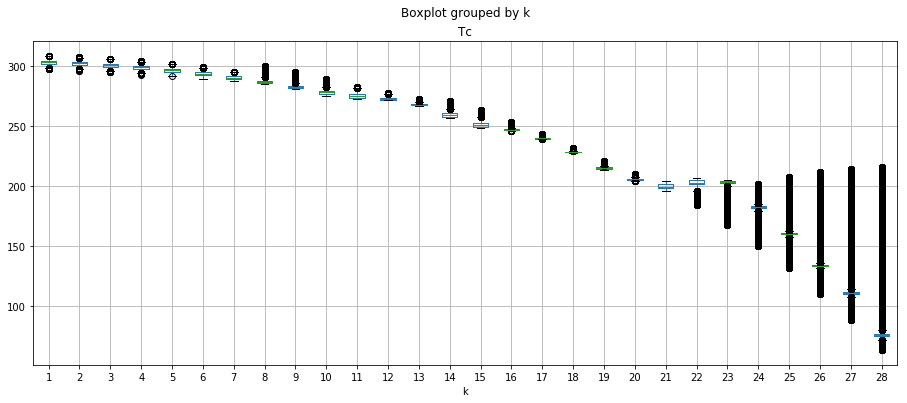

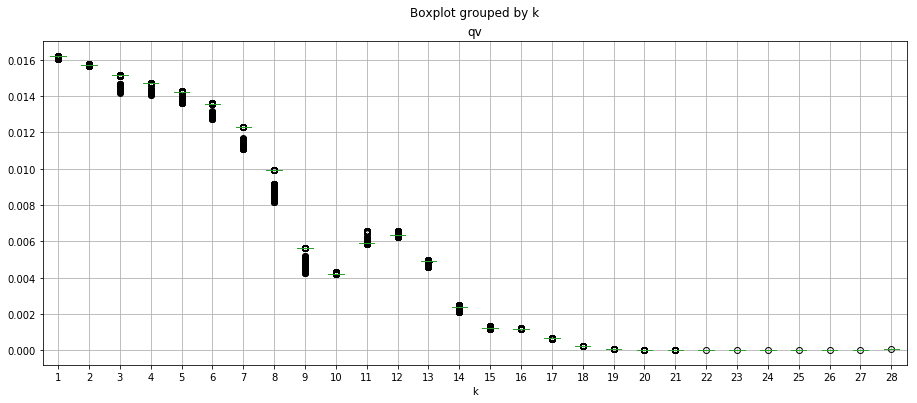

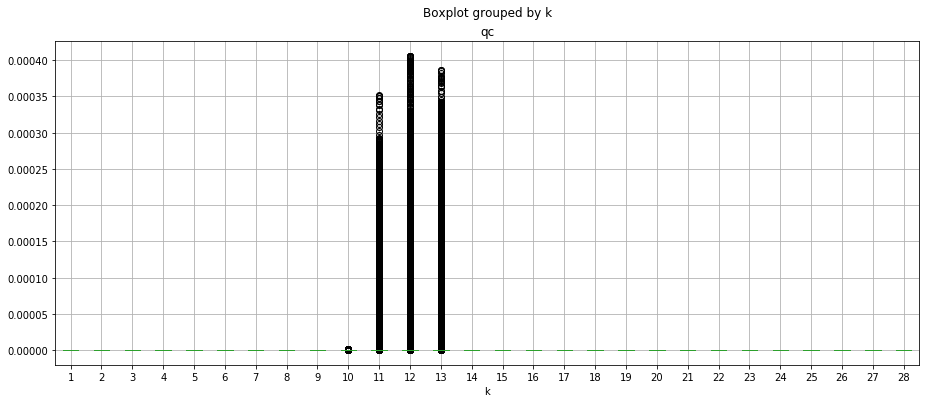

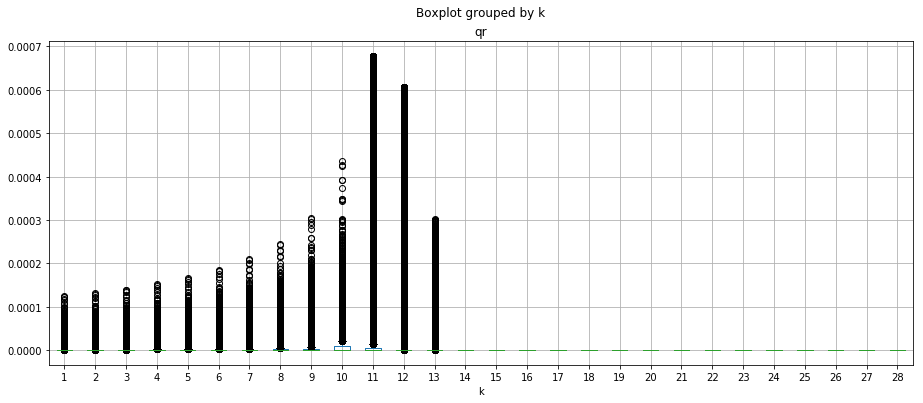

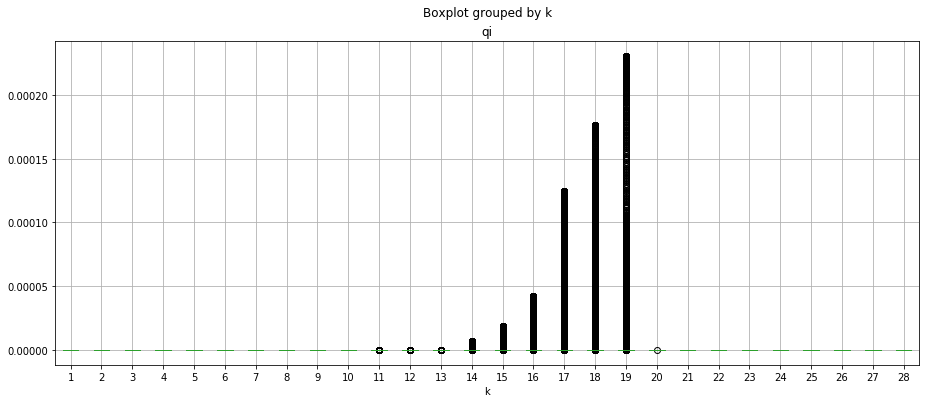

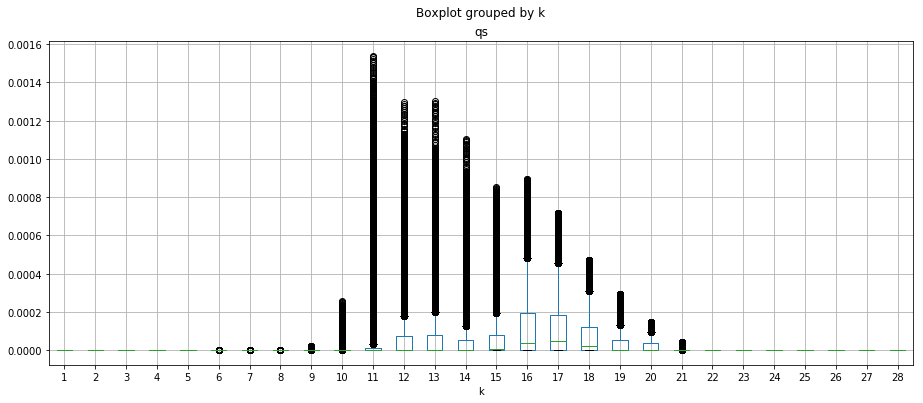

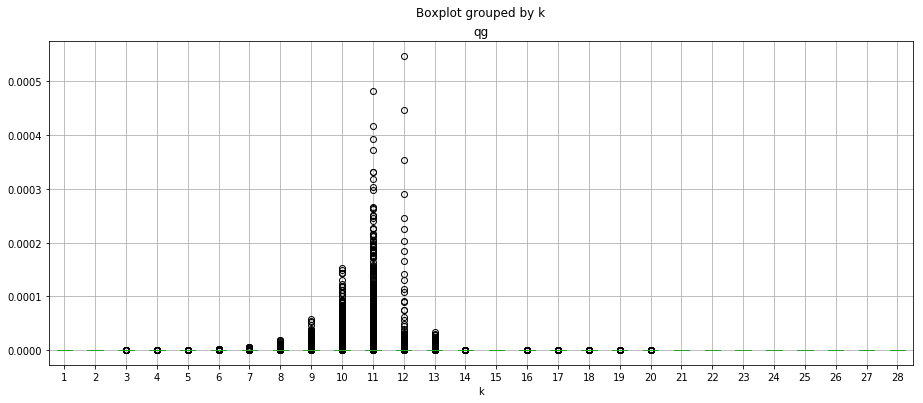

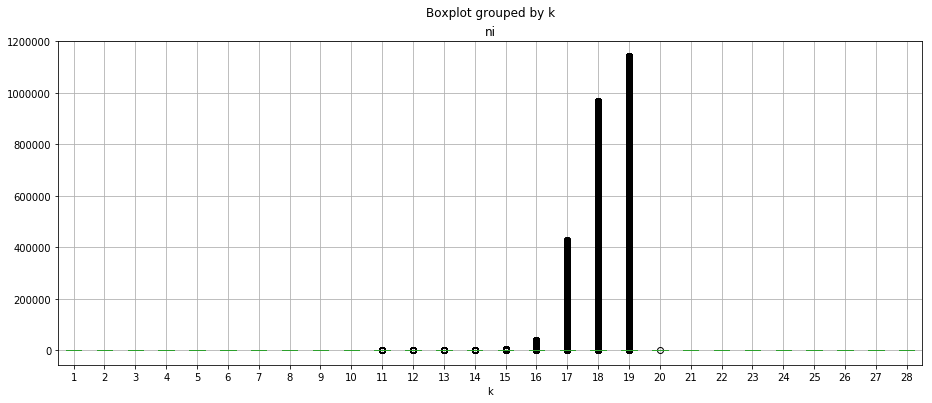

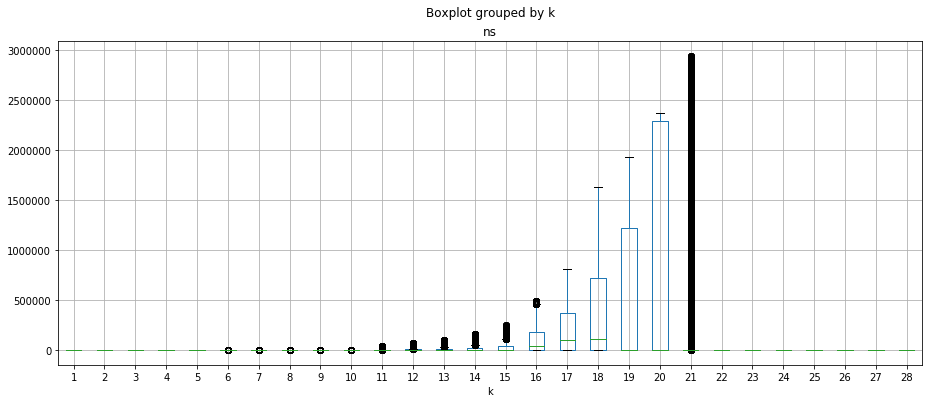

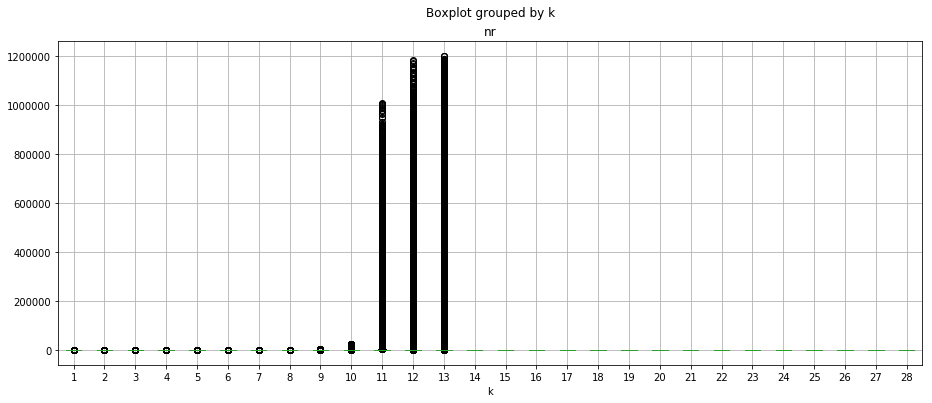

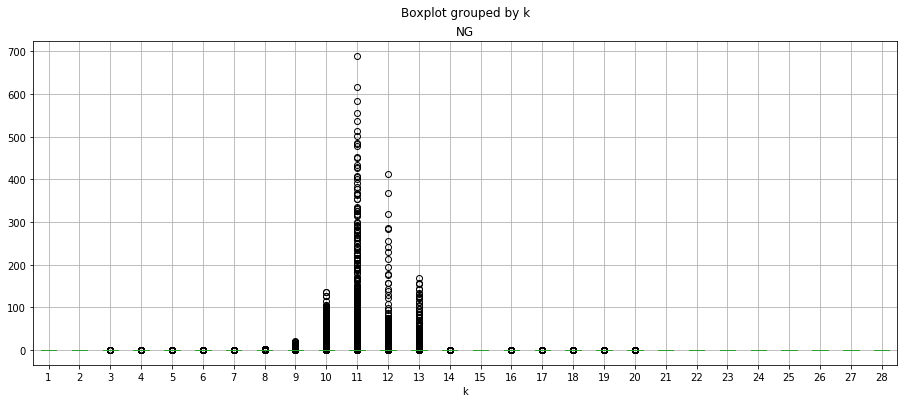

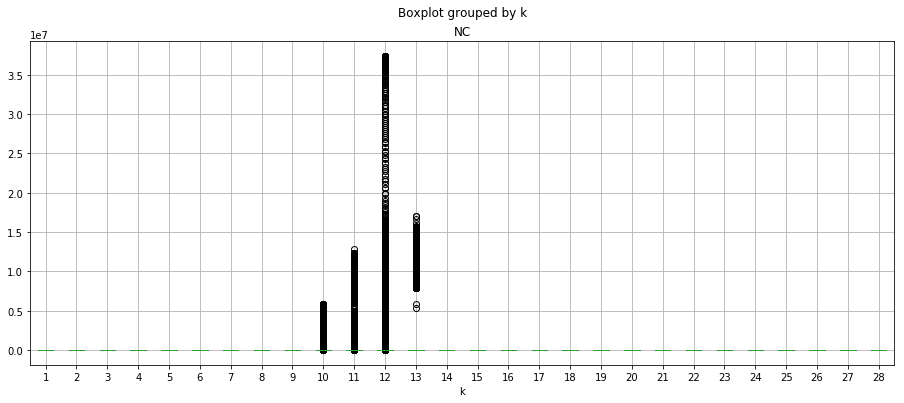

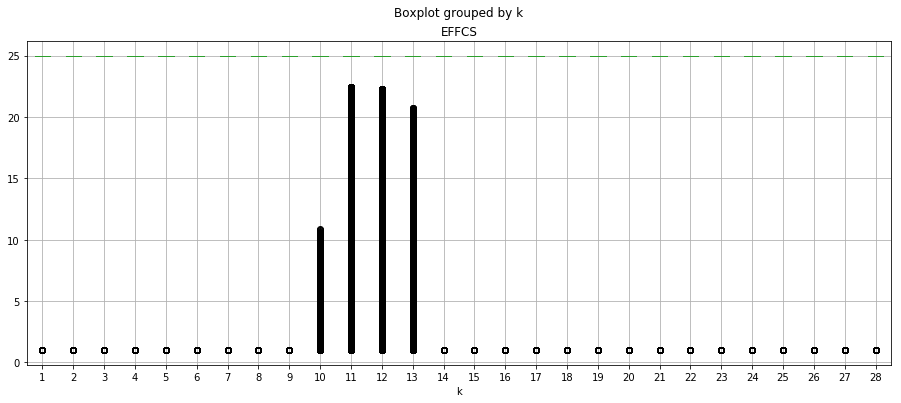

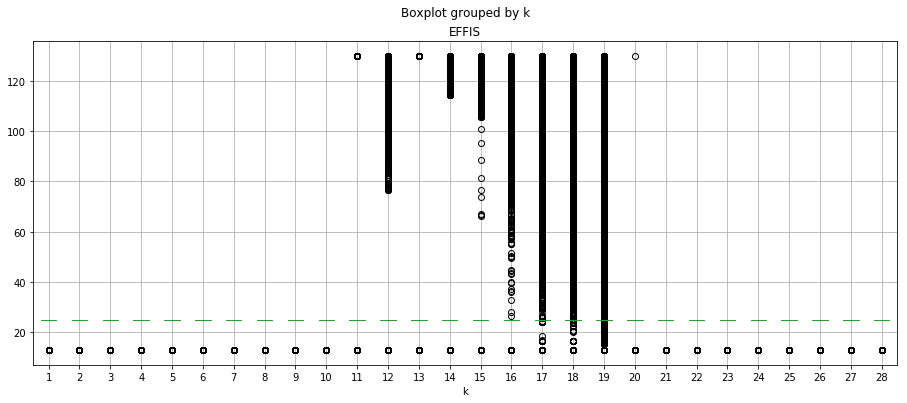

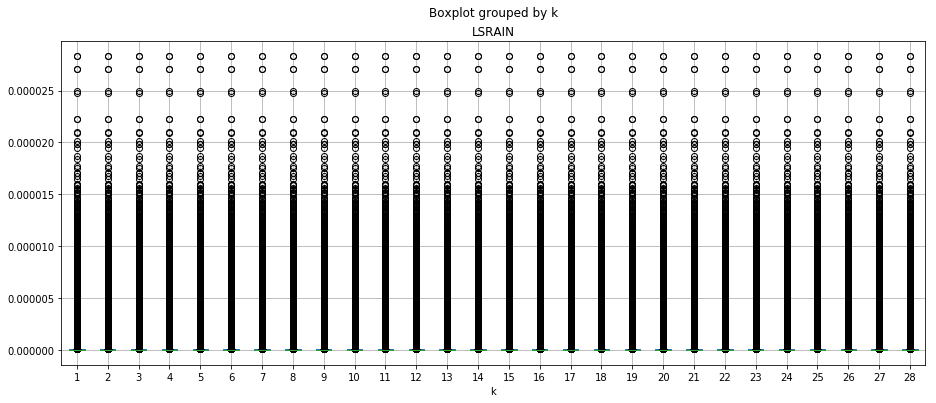

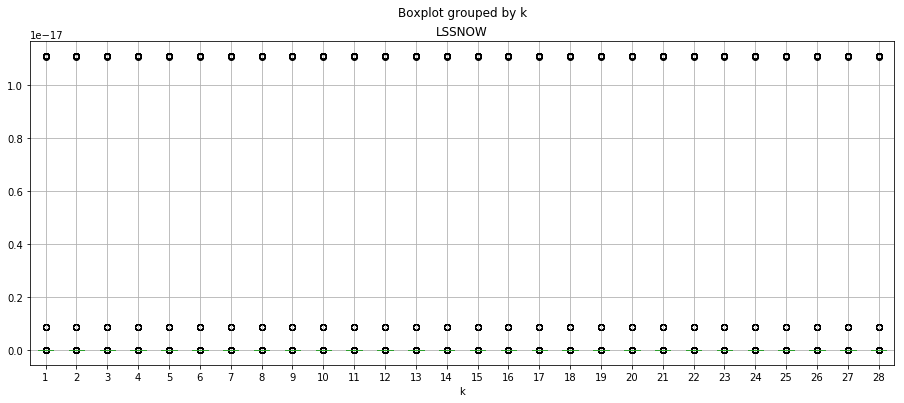

In [6]:
# Boxplot of variables through levels

for key in original_output_df.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    original_output_df.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

### Gráfico de perfil vertical das variáves de entrada em 3 timesteps

In [7]:
# Plot the vertical levels of first, 100th and last timestep

# first_timestep_input_df = original_input_df.head(k_max)
# med_timestep_input_df = original_input_df.loc[k_max00:k_max00+27]
# last_timestep_input_df = original_input_df.tail(k_max)

# idx_plot = 1
# plt.figure(figsize=(10, 10))
# for key in last_timestep_input_df.columns.tolist():
#     plt.subplot(7, 3, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.plot(first_timestep_input_df[key], first_timestep_input_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_input_df[key], med_timestep_input_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_input_df[key], last_timestep_input_df[["k"]], label="last timestep")
#     idx_plot += 1
# plt.legend(loc="upper left")
# plt.subplots_adjust(hspace=1, wspace=1)
# plt.show()


# first_timestep_output_df = original_output_df.head(k_max)
# med_timestep_output_df = original_output_df.loc[k_max01:k_max01+27]
# last_timestep_output_df = original_output_df.tail(k_max)

# idx_plot = 1
# for key in last_timestep_output_df.columns.tolist():
#     plt.subplot(4, 6, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.title("Output x Level")
#     plt.plot(first_timestep_output_df[key], first_timestep_output_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_output_df[key], med_timestep_output_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_output_df[key], last_timestep_output_df[["k"]], label="last timestep")
#     plt.legend()
# plt.show()

## Pré-processando a entrada (exemplos) e saídas (metas)
- Selecionamos as primeiras variáveis de entrada e saída que serão usadas no treinamento e na validação;
- também podemos criar novas variáveis como um composto de variáveis

In [8]:
def preprocess_features(input_df):
  """Prepares input features input_df

  Args:
    input data frame: A Pandas DataFrame expected to contain data from input data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
# All input variables
# "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
  selected_features = input_df[
    [
    "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"    
    ]]
  processed_features = selected_features.copy()
  return processed_features


def preprocess_targets(output_df):
  """Prepares target features (i.e., labels) from output_df

  Args:
    output_df: A Pandas DataFrame expected to contain data from output data set.
  Returns:
    A DataFrame that contains the target features.
  """
# All output variables
# "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
  output_targets = output_df [
      [
      "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
      ]
  ]
  return output_targets


# execute the pre processing
all_examples = preprocess_features(original_input_df)
all_targets = preprocess_targets(original_output_df)


### Funções de normalização

In [9]:
# Linear normalization (serie or numpy 1D array)
def linear_scale(serie_or_np_arr, min_val, max_val):
  scale = (max_val - min_val) / 2.0
  y = lambda x:((x - min_val) / scale) - 1.0
  return y(serie_or_np_arr)

# old bak
# def linear_scale(serie_or_np_arr):
#   min_val = serie_or_np_arr.min()
#   max_val = serie_or_np_arr.max()
#   scale = (max_val - min_val) / 2.0
#   y = lambda x:((x - min_val) / scale) - 1.0
#   return y(serie_or_np_arr), min_val, max_val


# Linear denormalization (serie or numpy 1D array)
#
# enter with min and max val of values before normalization
def delinear_scale(serie_or_np_arr, min_val, max_val):
  scale = (max_val - min_val) / 2.0
  y = lambda x:((x + 1.0) * scale) + min_val
  return y(serie_or_np_arr)


# Different normalilzation functions

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

### Normalização da base usando escala linear

Normalização das entradas para a escala -1, 1. para os primeiros testes

Como regra geral, o NN treina melhor quando os recursos de entrada estão aproximadamente na mesma escala.

Isso ajuda o NN a não ficar preso em etapas que são muito grandes em uma dimensão ou muito pequenas em outra.


In [1]:
def normalize_linear_scale(examples_dataframe, minmax_dict=None):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""

  # Convert pandas data into a dict of np arrays.
  processed_features = examples_dataframe.copy()

  for key,value in dict(examples_dataframe).items():
    if key != 'k':
      if minmax_dict is None:
        min_val = value.min()
        max_val = value.max()
      else:
        min_val = minmax_dict[key][0]
        max_val = minmax_dict[key][1]
      processed_features[key] = linear_scale(value, min_val, max_val)
  return processed_features


#### Boxplot das variáveis de entrada linearmente normalizadas

In [2]:
#
# code below just to show
#

normalized_all_examples = normalize_linear_scale(all_examples)

print("All normalized examples summary:")
display.display(normalized_all_examples.describe())

# Boxplot of variables through levels
for key in normalized_all_examples.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

NameError: name 'all_examples' is not defined

#### Boxplot das variáveis de saída linearmente normalizadas

In [ ]:
#
# code below just to show
#

normalized_all_targets = normalize_linear_scale(all_targets)

print("All normalized targets summary:")
display.display(normalized_all_targets.describe())

# Boxplot of variables through levels
for key in normalized_all_targets.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    normalized_all_targets.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

### Normalização da base usando diferentes escalas para cada variável

- Diferentes normalizações por variável, como linear, logarítimica e z-score


In [ ]:
def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  if len(examples_dataframe["k"]) > 0:
    processed_features["k"] = examples_dataframe["k"]

  for m_var in [ "si", "sl", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var], examples_dataframe[m_var].min(), examples_dataframe[m_var].max())

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    
  return processed_features


#### Boxplot das variáveis de entrada com diferentes normalizações

In [ ]:
normalized_all_examples = normalize_examples(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

print("All normalized examples summary:")
display.display(normalized_all_examples.describe())

print("All normalized targets summary:")
display.display(normalized_all_targets.describe())


# Boxplot of variables through levels
for key in normalized_all_examples.columns.tolist():
    if key == "k": continue
    # plt.subplot(6, 2, idx_plot)
    normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
plt.show()

## Amostras dos Conjuntos de treinamento e validação

Exibe  o resumo de entrada e saída de conjuntos de treinamento e validação, para verificar a homogeneidade desses conjuntos


In [ ]:
def get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, train_percent_size):
  # Choose the first x percent for training.
  all_size = len(normalized_all_examples)
  train_size = int(all_size * train_percent_size / k_max)*k_max
  print("train size = {}".format(train_size))

  normalized_training_examples = normalized_all_examples.head(train_size)
  normalized_training_targets = normalized_all_targets.head(train_size)

  # Choose the last (10%) (out of 265468) for validation.
  normalized_validation_examples = normalized_all_examples.iloc[train_size:]
  normalized_validation_targets = normalized_all_targets.iloc[train_size:]
  return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets


# versão atual que grava primeiro por variavel depois por nivel, e remove niveis de LSRAIN e LSSNOW
def get_df_col_k(df_orig, k_inicial, k_final, dic_var_levs_exclude=None):
  
  print(df_orig.columns)
  dic_var_levs_exclude_ok = { \
  'LSRAIN':range(2,29),
  'LSSNOW':range(2,29)
  }  
  if dic_var_levs_exclude is not None:
    dic_var_levs_exclude_ok.update(dic_var_levs_exclude)
    
  df_col_k = pd.DataFrame()
  for col in df_orig.columns.tolist():
    if col == 'k':
        continue
    for k in range(k_inicial, k_final + 1):
      df = df_orig.copy()
      df_k = df[df['k'] == k]
      if col in dic_var_levs_exclude_ok.keys() and k in dic_var_levs_exclude_ok[col]:
          continue
      df_col_k['{}_k{}'.format(col, k)] = df_k[col].to_numpy()
  return df_col_k


# versão anterior que grava primeiro por nivel depois por variavel
# def get_df_col_k(df_orig, k_inicial, k_final, dic_var_levs_exclude=None):
#   df_col_k = pd.DataFrame()
#   for k in range(k_inicial, k_final + 1):
#     df = df_orig.copy()
#     df_k = df[df['k'] == k]
#     for col in df.columns.tolist():
#       if col == 'k':
#         continue
#       if dic_var_levs_exclude is not None and col in dic_var_levs_exclude.keys():
#         if k in dic_var_levs_exclude[col]:
#           continue
#       df_col_k['{}_k{}'.format(col, k)] = df_k[col].to_numpy()
#   return df_col_k


def get_arr_2D_col_k(df_orig, colname, k_inicial, k_final):
  levels = k_final - k_inicial + 1
  rows_one_level = int(len(df_orig.index)/levels)
  arr_col_2d = np.zeros((rows_one_level, k_max))

  for k in range(k_inicial, k_final + 1):
    df = df_orig.copy()
    df_k = df[df['k'] == k]
    arr_col_2d[:, k-1] = df_k[colname].to_numpy()
 
  return arr_col_2d

In [ ]:
# Choose variables to train and validate
# Eliminate variables are not varying
# Separate 70% for training and 30# for validation

training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_percent_normalized_trainining_and_validation(all_examples, all_targets, 0.7)

print("Training examples summary:")
display.display(training_examples_tmp.describe())

print("Validation examples summary:")
display.display(validation_examples_tmp.describe())

print("Training targets summary:")
display.display(training_targets_tmp.describe())

print("Validation targets summary:")
display.display(validation_targets_tmp.describe())


In [ ]:
# Set using Variables per K
# training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_percent_normalized_trainining_and_validation(all_examples, all_targets, 0.7)

# k_inicial = 1
# k_final = k_max

# training_examples_tmp = get_df_col_k(training_examples_tmp, k_inicial, k_final)
# training_targets_tmp = get_df_col_k(training_targets_tmp, k_inicial, k_final)
# validation_examples_tmp = get_df_col_k(validation_examples_tmp, k_inicial, k_final)
# validation_targets_tmp = get_df_col_k(validation_targets_tmp, k_inicial, k_final)



# display.display(training_examples_tmp.describe())
# display.display(validation_examples_tmp.describe())
# display.display(training_targets_tmp.describe())
# display.display(validation_targets_tmp.describe())


# Treinamento da rede neural: Rotinas utilizadas


In [ ]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    print("Features:", features)
    print("Labels:", labels)
    return features, labels

In [ ]:
def use_tpu():
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    # para TF2
    # tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # https://www.tensorflow.org/guide/tpu
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  return tpu_strategy
  # with tpu_strategy.scope():
  #  code here

In [ ]:
def use_gpu():
# Using GPU ...  mais lento que TPU - mesmo temo que CPU ou pouco mais rápido:
# ex: 
#   INFO:tensorflow:global_step/sec: 299.778
#   INFO:tensorflow:loss = 3.5140946, step = 200 (0.332 sec)

  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

# use_gpu()
# with tf.device('/device:GPU:0') as gpu:
#     print("Gpu name={}".format(gpu))


In [ ]:
def get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=False):

  spinup_size = int(levels * spin_hours * 3600/delta_t) 
  total_size = len(original_input_df)
  no_spinup_size = total_size-spinup_size
  all_examples_tmp = original_input_df.tail(no_spinup_size)
  all_targets_tmp = original_output_df.tail(no_spinup_size)
  print("First 3 examples and targets for checking spinup start")
  display.display(all_examples_tmp.head(3))
  display.display(all_targets_tmp.head(3))

  if pre_process:
    # select initial filtered variables
    all_examples_tmp = preprocess_features(all_examples_tmp)
    all_targets_tmp = preprocess_targets(all_targets_tmp)

  return all_examples_tmp, all_targets_tmp, no_spinup_size

## Construção de Multilayer Perceptron customizável

In [ ]:
# Segunda versão da rede neural com multi-output regression (ou single)
from sklearn.model_selection import train_test_split

# get sample dataset
def get_dataset():
    X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
    return X, y


def get_custom_model(n_inputs, n_outputs, neurons_per_layer, optimizer='adam', loss='mse'):
    # dropout = Fraction of the input units to drop
    dropout = 0
    inputs = Input(shape=n_inputs)
    x = inputs
    for neurons in neurons_per_layer:
        x = Dense(neurons, activation='relu')(x)
    # TODO level_all = Dense(self.train_y.shape[1])(x)
    level_all = Dense(n_outputs)(x)
    model = Model(inputs=inputs, outputs=level_all)
    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# idem mas com Sequential - erro ?
# def get_custom_model(n_inputs, n_outputs, neurons_per_layer, optimizer='adam', loss='mse'):

#     model = keras.Sequential()
#     first = True
#     for neurons in neurons_per_layer:
#       if first:
#         model.add(Dense(neurons, input_dim=n_inputs, activation="relu"))
#         first = False
#       else:
#         model.add(Dense(neurons, activation="relu"))

#     model.add(Dense(n_outputs))
#     model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model
    

# get the model
def get_sample_model(n_inputs, n_outputs, loss='mae'):
    # losses = mean_squared_error, mae ... https://keras.io/api/losses/
    
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss=loss, optimizer='adam')
    return model


def get_curr_time():
    return datetime.now().strftime("%m-%d.%H.%M")


def get_tb_logdir_var(test_name, layers, epochs, target_var="ALL_VARS"):
  log_dir_test = get_tb_logdir_test(test_name)
  return "{}/{}__{}-layers__{}-epochs___{}".format(log_dir_test, target_var, layers, epochs, get_curr_time())


def create_tb_logdir_test(test_name):
  tb_logdir_test = get_tb_logdir_test(test_name)
  rmtree(tb_logdir_test, ignore_errors=True)
  os.makedirs(tb_logdir_test)
  return tb_logdir_test


def get_tb_logdir_test(test_name):
  return "{}/{}".format(tb_logdir_base, test_name)


def get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  test_dir_name = '{}_{}-inputs_{}-layers_{}-outputs_{}-epochs__{}'.format(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  return test_dir_name


def get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  save_dir='{}/saved_models'.format(colab_in_drive_root_dir)
  model_var_name_dir = '{}/{}'.format(save_dir, get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name))
  return model_var_name_dir


def get_drive_test_log_dir(test_name):
  drive_logs_test_dir = '{}/logs/{}'.format(colab_in_drive_root_dir, test_name)
  return drive_logs_test_dir


def create_drive_test_log_dir(test_name):
  drive_logs_test_dir = get_drive_test_log_dir(test_name)
  rmtree(drive_logs_test_dir, ignore_errors=True)
  os.makedirs(drive_logs_test_dir)
  return drive_logs_test_dir


def save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name='ALL_VARS'):
  model_var_name_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  rmtree(model_var_name_dir, ignore_errors=True)
  os.makedirs(model_var_name_dir)
  log_msg('Saving model in {} ...'.format(model_var_name_dir))
  
  model.save(model_var_name_dir)
  model.save(model_var_name_dir + '/tmp_model.h5')

  test_dir_name = get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  drive_logs_test_var_dir = '{}/{}'.format(drive_logs_test_dir, test_dir_name)
  copytree(log_dir_var, drive_logs_test_var_dir)
  log_msg('Saving logs in {} ...'.format(drive_logs_test_var_dir))


# train and evaluate a model using repeated k-fold cross-validation
def train_model(model, X, y, tb_log_dir, epochs=200, mode='split', n_splits=10, batch_size=64):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir) 
    log_msg("Start training")
    start = time.time()
    results = list()
    if len(X.shape) == 1:
        n_inputs = 1
    else:
        n_inputs = X.shape[1]
    if len(y.shape) == 1:
        n_outputs = 1
    else:
        n_outputs = y.shape[1]

    if mode == 'k-folds':
      # Using k-folds ---- bad- must use many splits (number of itens trained) - to slow
      #
      n_repeats = 2
      epochs_k = int(epochs / n_splits)
      cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
      first_time=True
      # enumerate folds
      for train_ix, test_ix in cv.split(X):
          # prepare data
          X_train, X_test = X[train_ix], X[test_ix]
          y_train, y_test = y[train_ix], y[test_ix]
          if first_time:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, callbacks=[tensorboard_callback], batch_size=batch_size, use_multiprocessing=True)
            first_time = False
          else:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, batch_size=batch_size, use_multiprocessing=True)
          # evaluate model on test set
          loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
          log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl, n_splits, model.loss, loss_metric))
          # store result
          results.append(loss_metric)

    elif mode == 'split':
      early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

      for spl in range(n_splits):
        # Train / test split division (20% of total = 0.2/0.9 = 0.22222)
        #
        X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=(0.2/0.9), random_state=None)
        # display.display(X_train.shape)
        # display.display(X_test.shape)
        # display.display(y_train.shape)
        # display.display(y_test.shape)
        
        model.fit(X_train, y_train, verbose=1, epochs=epochs, callbacks=[early_stop_callback, tensorboard_callback], batch_size=batch_size, use_multiprocessing=True)
        # evaluate model on test set
        loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
        log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl+1, n_splits, model.loss, loss_metric))
        results.append(loss_metric)

    end = time.time()
    log_msg("Training finished in {} seconds".format(end-start))
    log_msg( 'All training mse losses/rmse metric all spits: \n {}'.format(results))
    log_msg( '======> Test on TRAINING set: [{} loss, metric(rmse)]={}'.format(model.loss, loss_metric))
    return results


def validate_model(model, normalized_validation_examples, normalized_validation_targets, batch_size=64):
  log_msg("Validating model in test set ...")

  arr_input_val = normalized_validation_examples.to_numpy()
  if len(arr_input_val.shape) > 1:
    num_vars = arr_input_val.shape[1]
  else:
    num_vars = 1
  log_msg("Input Validation variables/size = {}/{}".format(num_vars, arr_input_val.shape[0])) 

  arr_output_val = normalized_validation_targets.to_numpy()
  if len(arr_output_val.shape) > 1:
    num_vars = arr_output_val.shape[1]
  else:
    num_vars = 1
  log_msg("Output Validation variables/size = {}/{}".format(num_vars, arr_output_val.shape[0])) 

  loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1, batch_size=batch_size, use_multiprocessing=True) 
  log_msg('=====> Final Test on VALIDATION set: [loss/rmse] = {}'.format(loss_metric_eval))


def log_msg(message):
  log_file = '{}/log_messages.txt'.format(get_drive_test_log_dir(test_name))
  f = open(log_file, 'a')
  f.write('\n' + message)
  print(message)
 

# sample execution
# #
# # load dataset
# X, y = get_dataset()
# n_inputs, n_outputs = X.shape[1], y.shape[1]
# print(n_inputs, n_outputs)
# n_outputs
# model = get_custom_model(n_inputs, n_outputs, [n_inputs, n_outputs]) #, 'mean_squared_error'
# # model = get_sample_model(n_inputs, n_outputs, 'loss_metric')
# test_name = 'kerastest'
# drive_logs_test_dir = create_drive_test_log_dir(test_name)

# # model.build()
# model.summary(print_fn=log_msg)
# plot_model(model, to_file='./model.png')
# train_model(model, X, y, drive_logs_test_dir, epochs=100, n_splits=3)



# Testes e validação

## Rotinas para cálculo de métricas sobre os resultados

In [ ]:
#
# rotinas para cálculo de métricas sobre os resultados
#

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def bias(actual: np.ndarray, predicted: np.ndarray):
    """ BIAS """
    return np.mean(_error(actual, predicted))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

    
def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def write_header_B(normalized_all_targets, writer):
  df_tmp = normalized_all_targets.copy()
  if 'k' in df_tmp: 
    df_tmp.drop(columns=['k'], inplace=True)
  writer.writerow(df_tmp.columns)
  df_tmp = None


def get_rmse_csv_writer():
  return get_csv_writer('log_rmse_tmp.csv')


def get_csv_writer(fname):
  log_file_name = '{}/{}'.format(get_drive_test_log_dir(test_name), fname)
  file = open(log_file_name, 'a+')
  writer = csv.writer(file)
  return writer, file


def get_mean_csv_writer():
  log_file_name = '{}/log_mean_tmp.csv'.format(get_drive_test_log_dir(test_name))
  file = open(log_file_name, 'a+')
  writer = csv.writer(file)
  return writer, file


def calc_rmse_B(normalized_validation_examples, normalized_validation_targets, writer):
  # validation on every line of output file

  arr_input_val = normalized_validation_examples.to_numpy()
  arr_output_val = normalized_validation_targets.to_numpy()

  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))

  line_rmse = []
  for col_idx in range(arr_output_val.shape[1]):
    line_rmse.append(rmse(y[:,col_idx], arr_output_val[:,col_idx]))
  writer.writerow(line_rmse)

  # just to calculate prediction of 1 pass into routine ...

  arr_input_val = normalized_validation_examples.tail(k_max).to_numpy()
  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time of 1 pass into routine MULTIPROCESSING in {} seconds".format(end-start))


def calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values, dic_var_default_values=None):
    
  writer_rmse, frmse = get_rmse_csv_writer()
  fbias_name = 'log_bias_tmp.csv'
  writer_bias, fbias = get_csv_writer(fbias_name)
  fmse_name = 'log_mse_tmp.csv'
  writer_mse, fmse = get_csv_writer(fmse_name)
  fmae_name = 'log_mae_tmp.csv'
  writer_mae, fmae = get_csv_writer(fmae_name)
  fmean_pred_name = 'log_mean_pred_tmp.csv'
  writer_mean_pred, fmean_pred = get_csv_writer(fmean_pred_name)
  fmean_obs_name = 'log_mean_obs_tmp.csv'
  writer_mean_obs, fmean_obs = get_csv_writer(fmean_obs_name)

  write_header_B(normalized_validation_targets, writer_rmse)
  write_header_B(normalized_validation_targets, writer_mse)
  write_header_B(normalized_validation_targets, writer_bias)
  write_header_B(normalized_validation_targets, writer_mae)
  write_header_B(normalized_validation_targets, writer_mean_pred)
  write_header_B(normalized_validation_targets, writer_mean_obs)

  arr_input_val = normalized_validation_examples.to_numpy()
  arr_output_val = normalized_validation_targets.to_numpy()

  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))

  line_bias = []
  line_mae = []
  line_rmse = []
  line_mse = []
  line_mean_pred = []
  line_mean_obs = []
  for col_idx in range(arr_output_val.shape[1]):
    line_mse.append(mse(arr_output_val[:,col_idx], y[:,col_idx]))
    line_rmse.append(rmse(arr_output_val[:,col_idx], y[:,col_idx]))
    line_bias.append(bias(arr_output_val[:,col_idx], y[:,col_idx]))
    line_mae.append(mae(arr_output_val[:,col_idx], y[:,col_idx]))
    line_mean_pred.append(np.average(y[:,col_idx]))
    line_mean_obs.append(np.average(arr_output_val[:,col_idx]))

  
  writer_rmse.writerow(line_rmse)
  writer_mse.writerow(line_mse)
  writer_bias.writerow(line_bias)
  writer_mae.writerow(line_mae)
  writer_mean_pred.writerow(line_mean_pred)
  writer_mean_obs.writerow(line_mean_obs)

  frmse.close()
  fmse.close()
  fbias.close()
  fmae.close()
  fmean_pred.close()
  fmean_obs.close()

  # convert cols to rows, putting zeros in rows without values
  #
  create_files_csv(all_targets_min_values, all_targets_max_values, 'log_rmse_tmp.csv', 'log_rmse.csv', 'log_rmse_denorm.csv', dic_var_default_values=dic_var_default_values)
  create_files_csv(all_targets_min_values, all_targets_max_values, fbias_name, 'log_bias.csv', 'log_bias_denorm.csv', dic_var_default_values=dic_var_default_values)
  create_files_csv(all_targets_min_values, all_targets_max_values, fmae_name, 'log_mae.csv', 'log_mae_denorm.csv', dic_var_default_values=dic_var_default_values)
  create_files_csv(all_targets_min_values, all_targets_max_values, fmse_name, 'log_mse.csv', 'log_mse_denorm.csv', dic_var_default_values=dic_var_default_values)  
  create_files_csv(all_targets_min_values, all_targets_max_values, fmean_pred_name, 'log_mean_pred.csv', 'log_mean_pred_denorm.csv', scale_or_delinear='delinear', dic_var_default_values=dic_var_default_values)
  create_files_csv(all_targets_min_values, all_targets_max_values, fmean_obs_name, 'log_mean_obs.csv', 'log_mean_obs_denorm.csv', scale_or_delinear='delinear', dic_var_default_values=dic_var_default_values)

  # just to calculate prediction of 1 pass into routine ...
  arr_input_val = normalized_validation_examples.tail(k_max).to_numpy()
  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time of 1 pass into routine MULTIPROCESSING in {} seconds".format(end-start))


def create_files_csv(min_values, max_values, log_tmp_file, new_log_filename, new_log_denorm_filename, scale_or_delinear='scale', dic_var_default_values=None):
  log_file_name = '{}/{}'.format(get_drive_test_log_dir(test_name), log_tmp_file)
  df = pd.read_csv(log_file_name)
  all_out_columns = ["Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"]
  df_t = pd.DataFrame(columns=all_out_columns)
  for col_name in all_out_columns:
      if scale_or_delinear == 'delinear' and dic_var_default_values is not None and col_name in dic_var_default_values.keys():
        df_t[col_name] = [dic_var_default_values[col_name]] * k_max
      else:
        df_t[col_name] = [0.0] * k_max
  df_t_denorm = df_t.copy()
  for col in df.columns:
      col_name_k = col.split("_k")
      col_name = col_name_k[0]
      k = int(col_name_k[1])
      df_t[col_name].iloc[k-1] = df[col].values[0]
      if scale_or_delinear == 'scale':
        df_t_denorm[col_name].iloc[k-1] = df[col].values[0] * (max_values[col_name] - min_values[col_name])
      else:  # delinear scale
        df_t_denorm[col_name].iloc[k-1] = delinear_scale(df[col].values[0], min_values[col_name], max_values[col_name])
  
  df_t.to_csv('{}/{}'.format(get_drive_test_log_dir(test_name), new_log_filename))
  df_t_denorm.to_csv('{}/{}'.format(get_drive_test_log_dir(test_name), new_log_denorm_filename))


def calc_rmse_A(normalized_validation_examples, normalized_validation_targets, writer, df_rmse, target_key):
  # validation on every line of output file

  line_rmse = []
  for k in range(1,29):
    df_examples = normalized_validation_examples.copy()
    df_examples_k = df_examples[df_examples['k'] == k]
    df_targets = normalized_validation_targets.copy()
    df_targets_k = df_targets[df_targets['k'] == k]
    df_targets_k.drop(columns=['k'], inplace=True)

    arr_input_val = df_examples_k.to_numpy()
    arr_output_val = df_targets_k.to_numpy()

    log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
    start = time.time()
    y = model.predict(arr_input_val, use_multiprocessing=True)
    end = time.time()
    log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))
    print('rmse = ', rmse(y, arr_output_val))
    line_rmse.append(rmse(y, arr_output_val))
    
  df_rmse[target_key] = line_rmse

  return df_rmse

In [ ]:
# all_out_columns = ["Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"]
# df_t = pd.DataFrame(columns=all_out_columns)

# ???????
# df_t["Tc"]=[1,2]
# df_t["Tc"]=[1,2]


### Preparação para os testes C6

In [ ]:
def get_data_for_test(all_examples, all_targets):

    all_minmax_values = {}
    for key in all_examples.columns:
      all_minmax_values[key] = [all_examples[key].min(), all_examples[key].max()]

    for key in all_targets.columns:
      if key not in all_minmax_values.keys():
        all_minmax_values[key] = [all_targets[key].min(), all_targets[key].max()]
      else:
        if all_targets[key].min() < all_minmax_values[key][0]:
          all_minmax_values[key][0] = all_targets[key].min()
        if all_targets[key].max() > all_minmax_values[key][1]:
          all_minmax_values[key][1] = all_targets[key].max()
    
#     # duplicate scale size
#     for key, value in all_minmax_values.items():
#       scale = value[1]-value[0]
#       value[0]=value[0]-half_scale
#       value[1]=value[1]+half_scale
    
    all_min_values = {k: all_minmax_values[k][0] for k in all_minmax_values.keys()}
    all_max_values = {k: all_minmax_values[k][1] for k in all_minmax_values.keys()}

    print('\n  all minmax values: ')
    print(all_minmax_values)
    
#     print('\n  all examples min and max values = ')
#     print( {k: [all_examples[k].min(), all_examples[k].max()] for k in all_examples.columns})
#     print('\n  all targets min and max values = ')
#     print( {k: [all_targets[k].min(), all_targets[k].max()] for k in all_targets.columns})
    
#     print('\n  min_values =', all_min_values)
#     print('\n  max_values =', all_max_values)


    normalized_all_examples = normalize_linear_scale(all_examples, all_minmax_values)
    normalized_all_targets = normalize_linear_scale(all_targets, all_minmax_values)

    normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
    get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)
    
    return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values
    

Após a execução dos testes, os logs ficam armazenados no google drive, para que não se percam na sessão do colab. Outro notebook foi criado para visualizar os resultados no Tensorboard.  
=>  https://colab.research.google.com/drive/1RiIXCWdcpGTdSLimPI3mJDWl7nj5fm1j?usp=sharing

## C) Testes com (k_max níveis x num_var) inputs e (k_max níveis x num_var outputs) (Uma predição por passagem na rotina)

- Utiliza 70% da base para treinamento, 20% para validação interna e 10% para validação independente
- Normalização linear em todas as var de entrada ou outras normalizações
- Faz a regressão para todas as variáveis de saída, para cada nível 

### Teste C.1
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camada oculta com 18 neurônios
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.1"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [18]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


#### Teste C.1.1
- Idem ao C.1, mas removendo normalização para cálculo do rmse
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camada oculta com 18 neurônios
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.1.1"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = all_examples
normalized_all_targets = all_targets

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [18]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


#### Teste C.1.2
- Idem C.1 mas removendo alguns niveis e colunas, como em B.1.2
- camada de entrada com 396 inputs
- 1 camada oculta com 18 neurônios
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.1.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

dic_var_levels_exclude = { \
  'qc':range(16,29),
  'qr':range(16,29),
  'qg':range(16,29),
  'nc':range(16,29),
  'nr':range(16,29),
  'ng':range(16,29),
  'sl':range(1,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [18]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


### Teste C.2
- Idem C.1 mas com 54 neurônios
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camada oculta com 54 neurônios
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [54]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


#### Teste C.2.2
- Idem C.2 mas removendo alguns niveis e colunas, como em B.1.2
- camada de entrada com (#TODO) inputs
- 1 camada oculta com 18 neurônios
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.2.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

dic_var_levels_exclude = { \
  'qc':range(16,29),
  'qr':range(16,29),
  'qg':range(16,29),
  'nc':range(16,29),
  'nr':range(16,29),
  'ng':range(16,29),
  'sl':range(1,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [54]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


### Teste C.3
- Idem C.1 mas com 2 camadas com 17 neurônios
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 2 camadas ocultas com 18 neurônios
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.3"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [18, 18]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


### Teste C.4
- Idem C.1 mas com com 108 neurônios
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camada oculta com 108 neurônios
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.4"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [108]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


#### Teste C.4.2
- Idem C.4 mas removendo alguns niveis e colunas, como em B.1.2
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camada oculta com 108 neurônios
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.4.2"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

dic_var_levels_exclude = { \
  'qc':range(16,29),
  'qr':range(16,29),
  'qg':range(16,29),
  'nc':range(16,29),
  'nr':range(16,29),
  'ng':range(16,29),
  'sl':range(1,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [108]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


### Teste C.5
- Idem C.1 mas com com 162 neurônios
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camada oculta com 162 neurônios
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.5"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [162]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)



### Teste C.6
- Idem C.1 mas com com 216 neurônios
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camada oculta com 216 neurônios
- camada de saída com 16 variáveis x k_max níveis -27 níveis LSRAIN LSSONW =  394 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [29]:
test_name = "teste_C.6"
levels = k_max
delta_t = 60
spin_hours = 24

all_spin_examples, all_spin_targets, no_spinup_size = get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=True)
    
normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
get_data_for_test(all_spin_examples, all_spin_targets)


drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

# Train model
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)

# use trained model
# model = load_model((model_dir + '/tmp_model.h5'))

validate_model(model, normalized_validation_examples, normalized_validation_targets)
dic_var_default_values = { \
  'qc': -1.0,
  'qr': -1.0,
  'qi': -1.0,
  'qs': -1.0,
  'ni': -1.0,
  'ns': -1.0,
  'nr': -1.0,
  'NG': -1.0,
  'NC': -1.0,
  'EFFCS': 0.64,
  'EFFIS': -0.8
}
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values)


# FKB Testing ...
#
print("colunas de entrada")
print(normalized_validation_examples.columns.values)
print("colunas de saída:")
print(normalized_validation_targets.columns.values)

arr_one_input_val = normalized_validation_examples.tail(1).to_numpy()
arr_one_output_val = normalized_validation_targets.tail(1).to_numpy()
print("\n\n FKB Testing")
print("input = ")
print(*arr_one_input_val[0], sep=", ")
print("output = ")
print(*arr_one_output_val[0], sep=", ")
           

y = model.predict(arr_one_input_val, use_multiprocessing=True)
print("prediction h5 = ")                  
print(y, sep=", ")
                  

from KerasWeightsProcessing.convert_weights import txt_to_h5, h5_to_txt

h5_to_txt(
    weights_file_name=model_dir + '/tmp_model.h5', 
    output_file_name=model_dir + '/fkb_model.txt'
)
copyfile(model_dir + '/fkb_model.txt', './fkb_model.txt')

print("\n\nprediction FORTRAN = \n ")                  
command_fkb = "../FKB/build/bin/test_keras ./fkb_model.txt"
!{command_fkb}

First 3 examples and targets for checking spinup start


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
40320,1,1.000000,0.000000,0.994964,300.562857,0.016230,0.000000,0.000040,0.000000,0.000000,0.000000,0.000000,0.000000,104.755400,0.000000,0.000000,0.000000,17.074271,99000.000000,0.008995
40321,2,0.989934,0.000000,0.981964,299.411690,0.015747,0.000000,0.000042,0.000000,0.000000,0.000000,0.000000,0.000000,122.572427,0.000000,0.000000,0.626396,25.509983,99000.000000,0.025968
40322,3,0.974009,0.000000,0.964137,297.945797,0.015145,0.000000,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,152.374717,0.000000,0.000000,0.331631,42.787101,99000.000000,0.043616


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
40320,1,300.495474,0.016258,0.000000,0.000040,0.000000,0.000000,0.000000,0.000000,0.000000,105.389888,0.000000,0.000000,25.000000,25.000000,0.000034,0.000000
40321,2,299.343378,0.015776,0.000000,0.000042,0.000000,0.000000,0.000000,0.000000,0.000000,123.334362,0.000000,0.000000,25.000000,25.000000,0.000034,0.000000
40322,3,297.875700,0.015174,0.000000,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,153.391180,0.000000,0.000000,25.000000,25.000000,0.000034,0.000000



  all minmax values: 
{'k': [1, 28], 'si': [0.0036691060265900003, 1.0], 'sl': [0.0015225021695299999, 0.994963901883], 'Tc': [64.12176166229999, 308.629704152], 'qv': [2.92705568e-06, 0.0163642884907], 'qc': [0.0, 0.0008159226470099999], 'qr': [0.0, 0.0006557531348180001], 'qi': [0.0, 0.00011183360996], 'qs': [0.0, 0.0017546842382200002], 'qg': [0.0, 0.00021544591451700003], 'ni': [0.0, 1145090.51334], 'ns': [0.0, 2912825.78761], 'nr': [0.0, 4522048.93832], 'NG': [0.0, 11243.0976757], 'NC': [0.0, 83625004.1341], 'tke': [0.0, 6.0], 'kzh': [0.03, 300.0], 'omega': [-1.0769567015000001, 0.432260810935], 'EFFCS': [1.0, 35.4545454545], 'EFFIS': [13.0, 130.0], 'LSRAIN': [-2.68342443526e-22, 0.00029176621046499997], 'LSSNOW': [-6.320975318359999e-27, 3.5668089276499997e-10]}
train size = 2153088
Index(['k', 'si', 'sl', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns',
       'nr', 'NG', 'NC', 'tke', 'kzh', 'omega'],
      dtype='object')
Index(['k', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'q

Epoch 119/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488
Epoch 120/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488
Epoch 121/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488
Epoch 122/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488
Epoch 123/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0488
Epoch 124/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487
Epoch 125/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487
Epoch 126/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487
Epoch 127/200
935/935 [==============================] -

935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473
Epoch 54/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474
Epoch 55/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474
Epoch 56/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473
Epoch 57/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473
Epoch 58/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473
Epoch 59/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474
Epoch 60/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474
Epoch 61/200
935/935 [==============================] - 2s 2ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467
Epoch 192/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464
Epoch 193/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466
Epoch 194/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466
Epoch 195/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465
Epoch 196/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464
Epoch 197/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464
Epoch 198/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464
Epoch 199/200
935/935 [==============================] - 2s 2ms/step -

Epoch 57/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460
Epoch 58/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460
Epoch 59/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460
Epoch 60/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460
Epoch 61/200
935/935 [==============================] - 3s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461
Epoch 62/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460
Epoch 63/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462
Epoch 64/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459
Epoch 65/200
935/935 [==============================] - 2s 2ms/s

935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458
Epoch 11/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456
Epoch 12/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457
Epoch 13/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457
Epoch 14/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456
Epoch 15/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458
Epoch 16/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456
Epoch 17/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455
Epoch 18/200
935/935 [==============================] - 2s 2ms/step - loss: 0

Epoch 1/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0453
Epoch 2/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 3/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452
Epoch 4/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 5/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452
Epoch 6/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451
Epoch 7/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455
Epoch 8/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0453
Epoch 9/200
935/935 [==============================] - 2s 2ms/step - los

935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451
Epoch 26/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448
Epoch 27/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451
Epoch 28/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449
Epoch 29/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 30/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449
Epoch 31/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 32/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452
Epoch 33/200
935/935 [==============================] - 2s 2ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448
Epoch 27/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 28/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448
Epoch 29/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449
Epoch 30/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449
Epoch 31/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449
Epoch 32/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448
Epoch 33/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449
Epoch 34/200
935/935 [==============================] - 2s 2ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 21/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 22/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 23/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452
Epoch 24/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451
Epoch 25/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 26/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 27/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 28/200
935/935 [==============================] - 2s 2ms/step - loss: 0

/home/denis/_COM_BACKUP/NN_BAM1d/bam1d_physics_nn/KerasWeightsProcessing/convert_weights.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)




prediction FORTRAN = 
 
Fortran runtime error: dimension of array B incorrect in MATMUL intrinsic

Error termination. Backtrace:
#0  0x7f7e8e6c52ed in ???
#1  0x7f7e8e6c5ed5 in ???
#2  0x7f7e8e6c61c7 in ???
#3  0x7f7e8e79dba4 in ???
#4  0x561563a745df in __mod_dense_layer_MOD_dense_forward
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/lib/mod_dense_layer.F90:102
#5  0x561563a711fd in __mod_network_MOD_output
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/lib/mod_network.F90:253
#6  0x561563a6fb88 in test_keras
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/tests/test_keras.F90:32
#7  0x561563a6f8fe in main
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/tests/test_keras.F90:12


#### Teste C.6.2 - dt 360
- Idem C.6 mas removendo niveis da entrada e da saída
- camada de entrada com 396 inputs
- 1 camada oculta com 216 neurônios
- camada de saída com 396 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.6.2"

get_data_for_test()
drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)
print('Scale examples:', scale_examples)
print('Scale targets:', scale_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

dic_var_levels_exclude = { \
  'qc':range(16,29),
  'qr':range(16,29),
  'qg':range(16,29),
  'nc':range(16,29),
  'nr':range(16,29),
  'ng':range(16,29),
  'sl':range(1,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude)


arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)

#### Teste C.6.3 - dt 60

- Idem C.6 mas removendo niveis da entrada e da saída
- camada de entrada com 217 inputs
- 1 camada oculta com 216 neurônios
- camada de saída com 227 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.6.3"

get_data_for_test()

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

dic_var_levels_exclude = { \
  'sl': range(1,29),                          
  'qv': range(20,29),                          
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
  'qs': list(range(1,11)) + [27, k_max],
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  
  'qg': list(range(1,11)) + list(range(16,29)),

  'ni': list(range(1,25)) + list(range(26,29)),
  'ns': list(range(1,15)) + [27, k_max],
  'nr': range(13,29),
  'NG': list(range(1,10)) + [22, 23, 27, k_max],
  'NC': [3, 4] + list(range(13,29)),

  'tke': list(range(9,24)) + [25, 26],
  'kzh': range(10,23),
  'omega': range(23,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)

dic_var_levels_exclude = { \
  'qv': range(20,29),                          
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
  'qs': list(range(1,11)) + [27, k_max],
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  
  'qg': list(range(1,10)) + [22, 23, 27, k_max],

  'ni': list(range(1,25)) + list(range(26,29)),
  'ns': list(range(1,15)) + [27, k_max],
  'nr': range(13,29),
  'NG': list(range(1,10)) + [22, 23, 27, k_max],
  'NC': [3, 4] + list(range(13,29)),

  'EFFCS': [3, 4]  + list(range(13,29)),
  'EFFIS': list(range(1,12)) + list(range(20,24)) + list(range(26,29))
}

normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude)


arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)


# train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
# save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')
rmtree('./tmp_model', ignore_errors=True)
copytree(model_dir, './tmp_model')
model = load_model('./tmp_model')

validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)

#### Teste C.6.4 - dt 60 - no spinup

- Evolução do C.6.4 alterando níveis e sem spinup
- camada de entrada com TODO inputs
- 1 camada oculta com 216 neurônios
- camada de saída com TODO outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [64]:
test_name = "teste_C.6.4_no_spinup"
levels = k_max
delta_t = 60
spin_hours = 24

all_spin_examples, all_spin_targets, no_spinup_size = get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=True)
    
normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
get_data_for_test(all_spin_examples, all_spin_targets)

drive_logs_test_dir = create_drive_test_log_dir(test_name)

k_inicial = 1
k_final = k_max

dic_var_levels_exclude = { \
  'sl': range(1,29),                          
  'qv': range(20,29),
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
  'qs': list(range(1,11)) + [27, k_max],
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  
  # 'qg': list(range(1,11)) + list(range(16,29)),
#   'ni': list(range(1,12)) + list(range(20,25)) + list(range(26,29)),
  'ni': list(range(1,25)) + list(range(26,29)),                          
  'ns': list(range(1,16)) + [27, k_max],
  'nr': range(13,29),
  'NG': list(range(1,9)) + [22, 23, 27, k_max],
  'NC': [3, 4] + list(range(13,29)),
  'tke': [1] + list(range(9,24)) + [25, 26],
  'kzh': range(10,23),
  'omega': range(23,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)

dic_var_levels_exclude = { \
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
  'qs': list(range(1,11)) + [27, k_max],
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  
  # 'qg': list(range(1,10)) + [22, 23, 27, k_max],
#   'ni': list(range(1,12)) + list(range(20,25)) + list(range(26,29)),
  'ni': list(range(1,25)) + list(range(26,29)),                          
  'ns': list(range(1,16)) + [27, k_max],
  'nr': range(13,29),
  'NG': list(range(1,9)) + [22, 23, 27, k_max],
  'NC': [3, 4] + list(range(13,29)),
  'EFFCS': list(range(1,8)) + list(range(9,29)),
  'EFFIS': list(range(1,29))
}

normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude)


arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()


# Train model parameters
#
loss_type = 'mse'
epochs=50
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

# Train model
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=1)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)

# use trained model
# model = load_model((model_dir + '/tmp_model.h5'))

validate_model(model, normalized_validation_examples, normalized_validation_targets)
dic_var_default_values = { \
  'qc': -1.0,
  'qr': -1.0,
  'qi': -1.0,
  'qs': -1.0,
  'ni': -1.0,
  'ns': -1.0,
  'nr': -1.0,
  'NG': -1.0,
  'NC': -1.0,
  'EFFCS': 0.64,
  'EFFIS': -0.8
}
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values)

# FKB Testing ...
#
print("colunas de entrada")
print(normalized_validation_examples.columns.values)
print("colunas de saída:")
print(normalized_validation_targets.columns.values)

arr_one_input_val = normalized_validation_examples.tail(1).to_numpy()
arr_one_output_val = normalized_validation_targets.tail(1).to_numpy()
print("\n\n FKB Testing")
print("input = ")
print(*arr_one_input_val[0], sep=", ")
print("output = ")
print(*arr_one_output_val[0], sep=", ")
           

y = model.predict(arr_one_input_val, use_multiprocessing=True)
print("prediction h5 = ")                  
print(y, sep=", ")
                  

from KerasWeightsProcessing.convert_weights import txt_to_h5, h5_to_txt

h5_to_txt(
    weights_file_name=model_dir + '/tmp_model.h5', 
    output_file_name=model_dir + '/fkb_model.txt'
)
copyfile(model_dir + '/fkb_model.txt', './fkb_model.txt')

# print("\n\nprediction FORTRAN = \n ")                  
# command_fkb = "../FKB/build/bin/test_keras ./fkb_model.txt"
# !{command_fkb}

First 3 examples and targets for checking spinup start


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
40320,1,1.000000,0.000000,0.994964,302.549145,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.284087,99000.000000,0.010031
40321,2,0.989934,0.000000,0.981964,301.403571,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.183763,16.809588,99000.000000,0.020962
40322,3,0.974009,0.000000,0.964137,299.894863,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164501,16.326761,99000.000000,0.032192


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
40320,1,302.549145,0.016781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
40321,2,301.403570,0.016364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
40322,3,299.894858,0.015746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000



  all minmax values: 
{'k': [1, 28], 'si': [0.0036691060265900003, 1.0], 'sl': [0.0015225021695299999, 0.994963901883], 'Tc': [100.655769623, 309.78247986400004], 'qv': [2.8533286421099997e-06, 0.016826697616999998], 'qc': [0.0, 0.000513125776036], 'qr': [0.0, 0.000495501239272], 'qi': [0.0, 1.55149020988e-08], 'qs': [0.0, 0.00125168602466], 'qg': [0.0, 7.972599041529999e-12], 'ni': [0.0, 6548.42241315], 'ns': [0.0, 23460897.786], 'nr': [0.0, 1040453.0793100001], 'NG': [0.0, 7.93049091719e-07], 'NC': [0.0, 18789516.9032], 'tke': [0.0, 6.0], 'kzh': [0.03, 300.0], 'omega': [-1.04042349225, 0.240343109468], 'EFFCS': [1.0, 25.0], 'EFFIS': [13.2852516982, 130.0], 'LSRAIN': [0.0, 1.23250871952e-05], 'LSSNOW': [0.0, 3.54494214396e-23]}
train size = 1397088
Index(['k', 'si', 'sl', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns',
       'nr', 'NG', 'NC', 'tke', 'kzh', 'omega'],
      dtype='object')
Index(['k', 'si', 'sl', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns',
       'nr',

607/607 [==============================] - 1s 2ms/step - loss: 7.0138e-04 - root_mean_squared_error: 0.0265
Epoch 50/50
174/174 [==============================] - 0s 1ms/step - loss: 7.3589e-04 - root_mean_squared_error: 0.0271
Test on TRAINING set. split 1 of 1 : [mse loss, metric(rmse)]=[0.0007358857546932995, 0.02712721936404705]
Training finished in 60.523382902145386 seconds
All training mse losses/rmse metric all spits: 
 [[0.0007358857546932995, 0.02712721936404705]]
======> Test on TRAINING set: [mse loss, metric(rmse)]=[0.0007358857546932995, 0.02712721936404705]
Saving model in /home/denis/_COM_BACKUP/NN_BAM1d/bam1d_data/Colab Notebooks/saved_models/teste_C.6.4_no_spinup_239-inputs_[216]-layers_176-outputs_50-epochs__ALL_VARS ...
INFO:tensorflow:Assets written to: /home/denis/_COM_BACKUP/NN_BAM1d/bam1d_data/Colab Notebooks/saved_models/teste_C.6.4_no_spinup_239-inputs_[216]-layers_176-outputs_50-epochs__ALL_VARS/assets
Saving logs in /home/denis/_COM_BACKUP/NN_BAM1d/bam1d_dat

/home/denis/_COM_BACKUP/NN_BAM1d/bam1d_physics_nn/KerasWeightsProcessing/convert_weights.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


'./fkb_model.txt'

#### Teste C.6.5 - dt 60

- Idem C.4 mas removendo apenas niveis da entrada (na tentativa da rede tentar decifrar todos os níveis das saídas)

In [56]:
test_name = "teste_C.6.5"

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
get_data_for_test()

drive_logs_test_dir = create_drive_test_log_dir(test_name)

k_inicial = 1
k_final = k_max

dic_var_levels_exclude = { \
  'sl': range(1,29),                          
  'qv': range(20,29),
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  

  # 'qg': list(range(1,11)) + list(range(16,29)),
  'ni': list(range(1,12)) + list(range(20,25)) + list(range(26,29)),
  'ns': list(range(1,16)) + [27, k_max],
  'nr': range(13,29),
  'NG': list(range(1,9)) + [22, 23, 27, k_max],
  'NC': [3, 4] + list(range(13,29)),
  'tke': [1] + list(range(9,24)) + [25, 26],
  'kzh': range(10,23),
  'omega': range(23,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)
arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

# Train model
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
# train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=10)
# save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)

# use trained model
model = load_model((model_dir + '/tmp_model.h5'))

validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values)

# FKB Testing ...
#
print("colunas de entrada")
print(normalized_validation_examples.columns.values)
print("colunas de saída:")
print(normalized_validation_targets.columns.values)

arr_one_input_val = normalized_validation_examples.tail(1).to_numpy()
arr_one_output_val = normalized_validation_targets.tail(1).to_numpy()
print("\n\n FKB Testing")
print("input = ")
print(*arr_one_input_val[0], sep=", ")
print("output = ")
print(*arr_one_output_val[0], sep=", ")
           

y = model.predict(arr_one_input_val, use_multiprocessing=True)
print("prediction h5 = ")                  
print(y, sep=", ")
                  

from KerasWeightsProcessing.convert_weights import txt_to_h5, h5_to_txt

h5_to_txt(
    weights_file_name=model_dir + '/tmp_model.h5', 
    output_file_name=model_dir + '/fkb_model.txt'
)
copyfile(model_dir + '/fkb_model.txt', './fkb_model.txt')

print("\n\nprediction FORTRAN = \n ")                  
command_fkb = "../FKB/build/bin/test_keras ./fkb_model.txt"
!{command_fkb}



  all minmax values: 
{'k': [1, 28], 'si': [0.0036691060265900003, 1.0], 'sl': [0.0015225021695299999, 0.994963901883], 'Tc': [100.655769623, 309.78247986400004], 'qv': [2.8533286421099997e-06, 0.0169416985124], 'qc': [0.0, 0.0005395298285269999], 'qr': [0.0, 0.000495501239272], 'qi': [0.0, 1.55149020988e-08], 'qs': [0.0, 0.00125168602466], 'qg': [0.0, 7.972599041529999e-12], 'ni': [0.0, 6548.42241315], 'ns': [0.0, 23859808.1385], 'nr': [0.0, 1040453.0793100001], 'NG': [0.0, 7.93049091719e-07], 'NC': [0.0, 18789516.9032], 'tke': [0.0, 6.0], 'kzh': [0.03, 300.0], 'omega': [-1.04042349225, 0.240343109468], 'EFFCS': [1.0, 29.5798022785], 'EFFIS': [13.2852516982, 130.0], 'LSRAIN': [0.0, 1.23250871952e-05], 'LSSNOW': [0.0, 3.33586392739e-14]}
train size = 1433376
Index(['k', 'si', 'sl', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns',
       'nr', 'NG', 'NC', 'tke', 'kzh', 'omega'],
      dtype='object')
Index(['k', 'si', 'sl', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns',
   

  0.93192348442302775       0.92063380821011043       0.90584775427917508       0.88985896928665897       0.86946452495263959       0.84335003556753119       0.81106600733615353       0.78330591840128339       0.75431010216925365       0.72431935875667552       0.68576487673404007       0.64798800258618816       0.60517533441701254       0.55068375539295289       0.48251203145431404       0.39525834875508392       0.31374815324219074       0.20498701438792225        7.9955271745540388E-002  -3.4407255374694960E-002  -9.0003842944513524E-002  -8.8342633840576903E-002 -0.15676521017448075      -0.35003986848424912       -8.1394711046553922E-002 -0.14878786765222579      -0.50058401302463640      -0.96709795429284084       0.98205507912628198       0.92970551825582370       0.87403618945172856       0.78452005888639442       0.72239453730826220       0.63007717903245308       0.52728027084788565       0.42749782103931833       0.32364841830442154       0.17308286259732947       -2.5505241

/home/denis/_COM_BACKUP/NN_BAM1d/bam1d_physics_nn/KerasWeightsProcessing/convert_weights.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)


### Teste C.7
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camadas ocultas [476] - mesma qtdd de neurônios que a camada de entrada
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.7"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))


# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


#### Teste C.7.5 - dt 60

- Idem C.6.5 - removendo apenas niveis da entrada (na tentativa da rede tentar decifrar todos os níveis das saídas)

In [ ]:
test_name = "teste_C.7.5"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

dic_var_levels_exclude = { \
  'sl': range(1,29),                          
  'qv': range(20,29),
  'qc': [3, 4] + list(range(13,29)),
  'qr': range(13,29),
  'qi': list(range(1,25)) + list(range(26,29)),
# TODO - checar porquê qg apresenta 0 e 1 na entrada, mas somente 0 na saída  

  # 'qg': list(range(1,11)) + list(range(16,29)),
  'ni': list(range(1,12)) + list(range(20,25)) + list(range(26,29)),
  'ns': list(range(1,16)) + [27, k_max],
  'nr': range(13,29),
  'NG': list(range(1,9)) + [22, 23, 27, k_max],
  'NC': [3, 4] + list(range(13,29)),
  'tke': [1] + list(range(9,24)) + [25, 26],
  'kzh': range(10,23),
  'omega': range(23,29)
}

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)

normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)


arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


### Teste C.8
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 2 camadas ocultas [216, 216]
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.8"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216, 216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


### Teste C.9
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camadas ocultas  [476, 476]
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.9"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476, 476]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))




# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, hidden_layers, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values)


### Teste C.10
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camadas ocultas [476, 216]
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.10"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476, 216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)

### Teste C.11
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camadas ocultas [476, 448]
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.11"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [476, 448]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)

### Teste C.12
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- camadas ocultas [k_max, k_max, k_max]
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.12"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [k_max, k_max, k_max]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs, target_key)
train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)

### Teste C.13
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- camadas ocultas [10, 10, 10]
- camada de saída com 16 variáveis x k_max níveis =  448 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [ ]:
test_name = "teste_C.13"

drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, 0.9)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [10, 10, 10]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

# Train model
#
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_i### Teste C.6
- Idem C.1 mas com com 216 neurônios
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camada oculta com 216 neurônios
- camada de saída com 16 variáveis x k_max níveis -27 níveis LSRAIN LSSONW =  394 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

test_name = "teste_C.6"
levels = k_max
delta_t = 60
spin_hours = 24

all_spin_examples, all_spin_targets, no_spinup_size = get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=True)
    
normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
get_data_for_test(all_spin_examples, all_spin_targets)


drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

# Train model
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)

# use trained model
# model = load_model((model_dir + '/tmp_model.h5'))

validate_model(model, normalized_validation_examples, normalized_validation_targets)
dic_var_default_values = { \
  'qc': -1.0,
  'qr': -1.0,
  'qi': -1.0,
  'qs': -1.0,
  'ni': -1.0,
  'ns': -1.0,
  'nr': -1.0,
  'NG': -1.0,
  'NC': -1.0,
  'EFFCS': 0.64,
  'EFFIS': -0.8
}
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values)


# FKB Testing ...
#
print("colunas de entrada")
print(normalized_validation_examples.columns.values)
print("colunas de saída:")
print(normalized_validation_targets.columns.values)

arr_one_input_val = normalized_validation_examples.tail(1).to_numpy()
arr_one_output_val = normalized_validation_targets.tail(1).to_numpy()
print("\n\n FKB Testing")
print("input = ")
print(*arr_one_input_val[0], sep=", ")
print("output = ")
print(*arr_one_output_val[0], sep=", ")
           

y = model.predict(arr_one_input_val, use_multiprocessing=True)
print("prediction h5 = ")                  
print(y, sep=", ")
                  

from KerasWeightsProcessing.convert_weights import txt_to_h5, h5_to_txt

h5_to_txt(
    weights_file_name=model_dir + '/tmp_model.h5', 
    output_file_name=model_dir + '/fkb_model.txt'
)
copyfile(model_dir + '/fkb_model.txt', './fkb_model.txt')

print("\n\nprediction FORTRAN = \n ")                  
command_fkb = "../FKB/build/bin/test_keras ./fkb_model.txt"
!{command_fkb}nput_train, arr_output_train, log_dir_var, epochs=epochs)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
validate_model(model, normalized_validation_examples, normalized_validation_targets)

### Teste D.6
- Idem C.6 mas com IOP 2014

- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 1 camada oculta com 216 neurônios
- camada de saída com 16 variáveis x k_max níveis -27 níveis LSRAIN LSSONW =  394 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [30]:
test_name = "teste_D.6"
levels = k_max
delta_t = 60
spin_hours = 24

all_spin_examples, all_spin_targets, no_spinup_size = get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=True)
    
normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
get_data_for_test(all_spin_examples, all_spin_targets)


drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

# Train model
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)

# use trained model
# model = load_model((model_dir + '/tmp_model.h5'))

validate_model(model, normalized_validation_examples, normalized_validation_targets)
dic_var_default_values = { \
  'qc': -1.0,
  'qr': -1.0,
  'qi': -1.0,
  'qs': -1.0,
  'ni': -1.0,
  'ns': -1.0,
  'nr': -1.0,
  'NG': -1.0,
  'NC': -1.0,
  'EFFCS': 0.378913,
  'EFFIS': -0.747816
}
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values)


# FKB Testing ...
#
print("colunas de entrada")
print(normalized_validation_examples.columns.values)
print("colunas de saída:")
print(normalized_validation_targets.columns.values)

arr_one_input_val = normalized_validation_examples.tail(1).to_numpy()
arr_one_output_val = normalized_validation_targets.tail(1).to_numpy()
print("\n\n FKB Testing")
print("input = ")
print(*arr_one_input_val[0], sep=", ")
print("output = ")
print(*arr_one_output_val[0], sep=", ")
           

y = model.predict(arr_one_input_val, use_multiprocessing=True)
print("prediction h5 = ")                  
print(y, sep=", ")
                  

from KerasWeightsProcessing.convert_weights import txt_to_h5, h5_to_txt

h5_to_txt(
    weights_file_name=model_dir + '/tmp_model.h5', 
    output_file_name=model_dir + '/fkb_model.txt'
)
copyfile(model_dir + '/fkb_model.txt', './fkb_model.txt')

print("\n\nprediction FORTRAN = \n ")                  
command_fkb = "../FKB/build/bin/test_keras ./fkb_model.txt"
!{command_fkb}

First 3 examples and targets for checking spinup start


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
40320,1,1.000000,0.000000,0.994964,300.562857,0.016230,0.000000,0.000040,0.000000,0.000000,0.000000,0.000000,0.000000,104.755400,0.000000,0.000000,0.000000,17.074271,99000.000000,0.008995
40321,2,0.989934,0.000000,0.981964,299.411690,0.015747,0.000000,0.000042,0.000000,0.000000,0.000000,0.000000,0.000000,122.572427,0.000000,0.000000,0.626396,25.509983,99000.000000,0.025968
40322,3,0.974009,0.000000,0.964137,297.945797,0.015145,0.000000,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,152.374717,0.000000,0.000000,0.331631,42.787101,99000.000000,0.043616


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
40320,1,300.495474,0.016258,0.000000,0.000040,0.000000,0.000000,0.000000,0.000000,0.000000,105.389888,0.000000,0.000000,25.000000,25.000000,0.000034,0.000000
40321,2,299.343378,0.015776,0.000000,0.000042,0.000000,0.000000,0.000000,0.000000,0.000000,123.334362,0.000000,0.000000,25.000000,25.000000,0.000034,0.000000
40322,3,297.875700,0.015174,0.000000,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,153.391180,0.000000,0.000000,25.000000,25.000000,0.000034,0.000000



  all minmax values: 
{'k': [1, 28], 'si': [0.0036691060265900003, 1.0], 'sl': [0.0015225021695299999, 0.994963901883], 'Tc': [64.12176166229999, 308.629704152], 'qv': [2.92705568e-06, 0.0163642884907], 'qc': [0.0, 0.0008159226470099999], 'qr': [0.0, 0.0006557531348180001], 'qi': [0.0, 0.00011183360996], 'qs': [0.0, 0.0017546842382200002], 'qg': [0.0, 0.00021544591451700003], 'ni': [0.0, 1145090.51334], 'ns': [0.0, 2912825.78761], 'nr': [0.0, 4522048.93832], 'NG': [0.0, 11243.0976757], 'NC': [0.0, 83625004.1341], 'tke': [0.0, 6.0], 'kzh': [0.03, 300.0], 'omega': [-1.0769567015000001, 0.432260810935], 'EFFCS': [1.0, 35.4545454545], 'EFFIS': [13.0, 130.0], 'LSRAIN': [-2.68342443526e-22, 0.00029176621046499997], 'LSSNOW': [-6.320975318359999e-27, 3.5668089276499997e-10]}
train size = 2153088
Index(['k', 'si', 'sl', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns',
       'nr', 'NG', 'NC', 'tke', 'kzh', 'omega'],
      dtype='object')
Index(['k', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'q

Epoch 119/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494
Epoch 120/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493
Epoch 121/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493
Epoch 122/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491
Epoch 123/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491
Epoch 124/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491
Epoch 125/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491
Epoch 126/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491
Epoch 127/200
935/935 [==============================] -

935/935 [==============================] - 2s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476
Epoch 54/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475
Epoch 55/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476
Epoch 56/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475
Epoch 57/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476
Epoch 58/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474
Epoch 59/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475
Epoch 60/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475
Epoch 61/200
935/935 [==============================] - 2s 2ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466
Epoch 192/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465
Epoch 193/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465
Epoch 194/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465
Epoch 195/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464
Epoch 196/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466
Epoch 197/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465
Epoch 198/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465
Epoch 199/200
935/935 [==============================] - 2s 2ms/step -

935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460
Epoch 129/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459
Epoch 130/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459
Epoch 131/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460
Epoch 132/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460
Epoch 133/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460
Epoch 134/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458
Epoch 135/200
935/935 [==============================] - 3s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458
Epoch 136/200
935/935 [==============================] - 2s 2ms/step -

935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455
Epoch 66/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0453
Epoch 67/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 68/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455
Epoch 69/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0453
Epoch 70/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 71/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0453
Epoch 72/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 73/200
935/935 [==============================] - 2s 2ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 19/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 20/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 21/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455
Epoch 22/200
935/935 [==============================] - 3s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454
Epoch 23/200
935/935 [==============================] - 3s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455
Epoch 24/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456
Epoch 25/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455
Epoch 26/200
935/935 [==============================] - 2s 2ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 14/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 15/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 16/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450
Epoch 17/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451
Epoch 18/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451
Epoch 19/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451
Epoch 20/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452
Epoch 21/200
935/935 [==============================] - 2s 2ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446
Epoch 63/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447
Epoch 64/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446
Epoch 65/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448
Epoch 66/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448
Epoch 67/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445
Epoch 68/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447
Epoch 69/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447
Epoch 70/200
935/935 [==============================] - 2s 2ms/step - loss: 0

Prediction time MULTIPROCESSING in 0.19656014442443848 seconds
predicting 28 registers 
Prediction time of 1 pass into routine MULTIPROCESSING in 0.0243072509765625 seconds
colunas de entrada
['si_k1' 'si_k2' 'si_k3' 'si_k4' 'si_k5' 'si_k6' 'si_k7' 'si_k8' 'si_k9'
 'si_k10' 'si_k11' 'si_k12' 'si_k13' 'si_k14' 'si_k15' 'si_k16' 'si_k17'
 'si_k18' 'si_k19' 'si_k20' 'si_k21' 'si_k22' 'si_k23' 'si_k24' 'si_k25'
 'si_k26' 'si_k27' 'si_k28' 'sl_k1' 'sl_k2' 'sl_k3' 'sl_k4' 'sl_k5'
 'sl_k6' 'sl_k7' 'sl_k8' 'sl_k9' 'sl_k10' 'sl_k11' 'sl_k12' 'sl_k13'
 'sl_k14' 'sl_k15' 'sl_k16' 'sl_k17' 'sl_k18' 'sl_k19' 'sl_k20' 'sl_k21'
 'sl_k22' 'sl_k23' 'sl_k24' 'sl_k25' 'sl_k26' 'sl_k27' 'sl_k28' 'Tc_k1'
 'Tc_k2' 'Tc_k3' 'Tc_k4' 'Tc_k5' 'Tc_k6' 'Tc_k7' 'Tc_k8' 'Tc_k9' 'Tc_k10'
 'Tc_k11' 'Tc_k12' 'Tc_k13' 'Tc_k14' 'Tc_k15' 'Tc_k16' 'Tc_k17' 'Tc_k18'
 'Tc_k19' 'Tc_k20' 'Tc_k21' 'Tc_k22' 'Tc_k23' 'Tc_k24' 'Tc_k25' 'Tc_k26'
 'Tc_k27' 'Tc_k28' 'qv_k1' 'qv_k2' 'qv_k3' 'qv_k4' 'qv_k5' 'qv_k6' 'qv_k7'
 'qv_k8' 'qv

/home/denis/_COM_BACKUP/NN_BAM1d/bam1d_physics_nn/KerasWeightsProcessing/convert_weights.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)




prediction FORTRAN = 
 
Fortran runtime error: dimension of array B incorrect in MATMUL intrinsic

Error termination. Backtrace:
#0  0x7fecedf822ed in ???
#1  0x7fecedf82ed5 in ???
#2  0x7fecedf831c7 in ???
#3  0x7fecee05aba4 in ???
#4  0x55b508d1f5df in __mod_dense_layer_MOD_dense_forward
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/lib/mod_dense_layer.F90:102
#5  0x55b508d1c1fd in __mod_network_MOD_output
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/lib/mod_network.F90:253
#6  0x55b508d1ab88 in test_keras
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/tests/test_keras.F90:32
#7  0x55b508d1a8fe in main
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/tests/test_keras.F90:12


### Teste D.8
- Idem C.8 mas com IOP 2014

- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- 2 camada oculta com 216 neurônios
- camada de saída com 16 variáveis x k_max níveis -27 níveis LSRAIN LSSONW =  394 outnputs
- Executar a rede nerual com normalização linear
- utilizando esquema de 5 splits e Early stop

In [38]:
test_name = "teste_D.8"
levels = k_max
delta_t = 60
spin_hours = 24

all_spin_examples, all_spin_targets, no_spinup_size = get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=True)
    
normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
get_data_for_test(all_spin_examples, all_spin_targets)


drive_logs_test_dir = create_drive_test_log_dir(test_name)
# drive_logs_test_dir = get_drive_test_log_dir(test_name)

k_inicial = 1
k_final = k_max

normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final)
normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final)
normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final)
normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final)

arr_input_train = normalized_training_examples.to_numpy()
arr_output_train = normalized_training_targets.to_numpy()

# Train model parameters
#
loss_type = 'mse'
epochs=200
n_inputs = arr_input_train.shape[1]
hidden_layers = [216, 216]  
n_outputs = arr_output_train.shape[1]

model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type) 
model.summary(print_fn=log_msg)

log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

# Train model
log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=10)
save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)

# use trained model
# model = load_model((model_dir + '/tmp_model.h5'))

validate_model(model, normalized_validation_examples, normalized_validation_targets)
dic_var_default_values = { \
  'qc': -1.0,
  'qr': -1.0,
  'qi': -1.0,
  'qs': -1.0,
  'ni': -1.0,
  'ns': -1.0,
  'nr': -1.0,
  'NG': -1.0,
  'NC': -1.0,
  'EFFCS': 0.378913,
  'EFFIS': -0.747816
}
calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values)


# FKB Testing ...
#
print("colunas de entrada")
print(normalized_validation_examples.columns.values)
print("colunas de saída:")
print(normalized_validation_targets.columns.values)

arr_one_input_val = normalized_validation_examples.tail(1).to_numpy()
arr_one_output_val = normalized_validation_targets.tail(1).to_numpy()
print("\n\n FKB Testing")
print("input = ")
print(*arr_one_input_val[0], sep=", ")
print("output = ")
print(*arr_one_output_val[0], sep=", ")
           

y = model.predict(arr_one_input_val, use_multiprocessing=True)
print("prediction h5 = ")                  
print(y, sep=", ")
                  

from KerasWeightsProcessing.convert_weights import txt_to_h5, h5_to_txt

h5_to_txt(
    weights_file_name=model_dir + '/tmp_model.h5', 
    output_file_name=model_dir + '/fkb_model.txt'
)
copyfile(model_dir + '/fkb_model.txt', './fkb_model.txt')

print("\n\nprediction FORTRAN = \n ")                  
command_fkb = "../FKB/build/bin/test_keras ./fkb_model.txt"
!{command_fkb}

First 3 examples and targets for checking spinup start


,k,si,si_kmax_+_1,sl,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,tke,kzh,gps,omega
40320,1,1.000000,0.000000,0.994964,300.562857,0.016230,0.000000,0.000040,0.000000,0.000000,0.000000,0.000000,0.000000,104.755400,0.000000,0.000000,0.000000,17.074271,99000.000000,0.008995
40321,2,0.989934,0.000000,0.981964,299.411690,0.015747,0.000000,0.000042,0.000000,0.000000,0.000000,0.000000,0.000000,122.572427,0.000000,0.000000,0.626396,25.509983,99000.000000,0.025968
40322,3,0.974009,0.000000,0.964137,297.945797,0.015145,0.000000,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,152.374717,0.000000,0.000000,0.331631,42.787101,99000.000000,0.043616


,k,Tc,qv,qc,qr,qi,qs,qg,ni,ns,nr,NG,NC,EFFCS,EFFIS,LSRAIN,LSSNOW
40320,1,300.495474,0.016258,0.000000,0.000040,0.000000,0.000000,0.000000,0.000000,0.000000,105.389888,0.000000,0.000000,25.000000,25.000000,0.000034,0.000000
40321,2,299.343378,0.015776,0.000000,0.000042,0.000000,0.000000,0.000000,0.000000,0.000000,123.334362,0.000000,0.000000,25.000000,25.000000,0.000034,0.000000
40322,3,297.875700,0.015174,0.000000,0.000045,0.000000,0.000000,0.000000,0.000000,0.000000,153.391180,0.000000,0.000000,25.000000,25.000000,0.000034,0.000000



  all minmax values: 
{'k': [1, 28], 'si': [0.0036691060265900003, 1.0], 'sl': [0.0015225021695299999, 0.994963901883], 'Tc': [64.12176166229999, 308.629704152], 'qv': [2.92705568e-06, 0.0163642884907], 'qc': [0.0, 0.0008159226470099999], 'qr': [0.0, 0.0006557531348180001], 'qi': [0.0, 0.00011183360996], 'qs': [0.0, 0.0017546842382200002], 'qg': [0.0, 0.00021544591451700003], 'ni': [0.0, 1145090.51334], 'ns': [0.0, 2912825.78761], 'nr': [0.0, 4522048.93832], 'NG': [0.0, 11243.0976757], 'NC': [0.0, 83625004.1341], 'tke': [0.0, 6.0], 'kzh': [0.03, 300.0], 'omega': [-1.0769567015000001, 0.432260810935], 'EFFCS': [1.0, 35.4545454545], 'EFFIS': [13.0, 130.0], 'LSRAIN': [-2.68342443526e-22, 0.00029176621046499997], 'LSSNOW': [-6.320975318359999e-27, 3.5668089276499997e-10]}
train size = 2153088
Index(['k', 'si', 'sl', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns',
       'nr', 'NG', 'NC', 'tke', 'kzh', 'omega'],
      dtype='object')
Index(['k', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'q

Epoch 118/200
935/935 [==============================] - 2s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422
Epoch 119/200
935/935 [==============================] - 2s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422
Epoch 120/200
935/935 [==============================] - 2s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424
Epoch 121/200
935/935 [==============================] - 3s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420
Epoch 122/200
935/935 [==============================] - 2s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423
Epoch 123/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422
Epoch 124/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 125/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421
Epoch 126/200
935/935 [==============================] -

935/935 [==============================] - 2s 2ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395
Epoch 53/200
935/935 [==============================] - 2s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389
Epoch 54/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390
Epoch 55/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389
Epoch 56/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391
Epoch 57/200
935/935 [==============================] - 4s 4ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390
Epoch 58/200
935/935 [==============================] - 3s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390
Epoch 59/200
935/935 [==============================] - 3s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389
Epoch 60/200
935/935 [==============================] - 2s 3ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373
Epoch 191/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374
Epoch 192/200
935/935 [==============================] - 2s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373
Epoch 193/200
935/935 [==============================] - 3s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374
Epoch 194/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376
Epoch 195/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372
Epoch 196/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374
Epoch 197/200
935/935 [==============================] - 3s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373
Epoch 198/200
935/935 [==============================] - 3s 3ms/step -

935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365
Epoch 128/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363
Epoch 129/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366
Epoch 130/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364
Epoch 131/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364
Epoch 132/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365
Epoch 133/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363
Epoch 134/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365
Epoch 135/200
935/935 [==============================] - 2s 2ms/step -

935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357
Epoch 58/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357
Epoch 59/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358
Epoch 60/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357
Epoch 61/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355
Epoch 62/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355
Epoch 63/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355
Epoch 64/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356
Epoch 65/200
935/935 [==============================] - 2s 2ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351
Epoch 45/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352
Epoch 46/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350
Epoch 47/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349
Epoch 48/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349
Epoch 49/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351
Epoch 50/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349
Epoch 51/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0350
Epoch 52/200
935/935 [==============================] - 2s 2ms/step - loss: 0

935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347
Epoch 115/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346
Epoch 116/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346
Epoch 117/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345
Epoch 118/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347
Epoch 119/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344
Epoch 120/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346
Epoch 121/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346
Epoch 122/200
935/935 [==============================] - 2s 2ms/step -

935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342
Epoch 12/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341
Epoch 13/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341
Epoch 14/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342
Epoch 15/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339
Epoch 16/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341
Epoch 17/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341
Epoch 18/200
935/935 [==============================] - 2s 2ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342
Epoch 19/200
935/935 [==============================] - 2s 2ms/step - loss: 0

INFO:tensorflow:Assets written to: /home/denis/_COM_BACKUP/NN_BAM1d/bam1d_data/Colab Notebooks/saved_models/teste_D.8_476-inputs_[216, 216]-layers_394-outputs_200-epochs__ALL_VARS/assets
Saving logs in /home/denis/_COM_BACKUP/NN_BAM1d/bam1d_data/Colab Notebooks/logs/teste_D.8/teste_D.8_476-inputs_[216, 216]-layers_394-outputs_200-epochs__ALL_VARS ...
Validating model in test set ...
Input Validation variables/size = 476/8545
Output Validation variables/size = 394/8545
134/134 [==============================] - 0s 2ms/step - loss: 0.0049 - root_mean_squared_error: 0.0699
=====> Final Test on VALIDATION set: [loss/rmse] = [0.0048890006728470325, 0.06992138922214508]
predicting 8545 registers 
Prediction time MULTIPROCESSING in 0.319627046585083 seconds
predicting 28 registers 
Prediction time of 1 pass into routine MULTIPROCESSING in 0.029814720153808594 seconds
colunas de entrada
['si_k1' 'si_k2' 'si_k3' 'si_k4' 'si_k5' 'si_k6' 'si_k7' 'si_k8' 'si_k9'
 'si_k10' 'si_k11' 'si_k12' 'si_k13

/home/denis/_COM_BACKUP/NN_BAM1d/bam1d_physics_nn/KerasWeightsProcessing/convert_weights.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)




prediction FORTRAN = 
 
Fortran runtime error: dimension of array B incorrect in MATMUL intrinsic

Error termination. Backtrace:
#0  0x7fc7ead2d2ed in ???
#1  0x7fc7ead2ded5 in ???
#2  0x7fc7ead2e1c7 in ???
#3  0x7fc7eae05ba4 in ???
#4  0x5569fd5125df in __mod_dense_layer_MOD_dense_forward
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/lib/mod_dense_layer.F90:102
#5  0x5569fd50f1fd in __mod_network_MOD_output
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/lib/mod_network.F90:253
#6  0x5569fd50db88 in test_keras
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/tests/test_keras.F90:32
#7  0x5569fd50d8fe in main
	at /home/denis/_COM_BACKUP/NN_BAM1d/FKB/src/tests/test_keras.F90:12


# Resultados

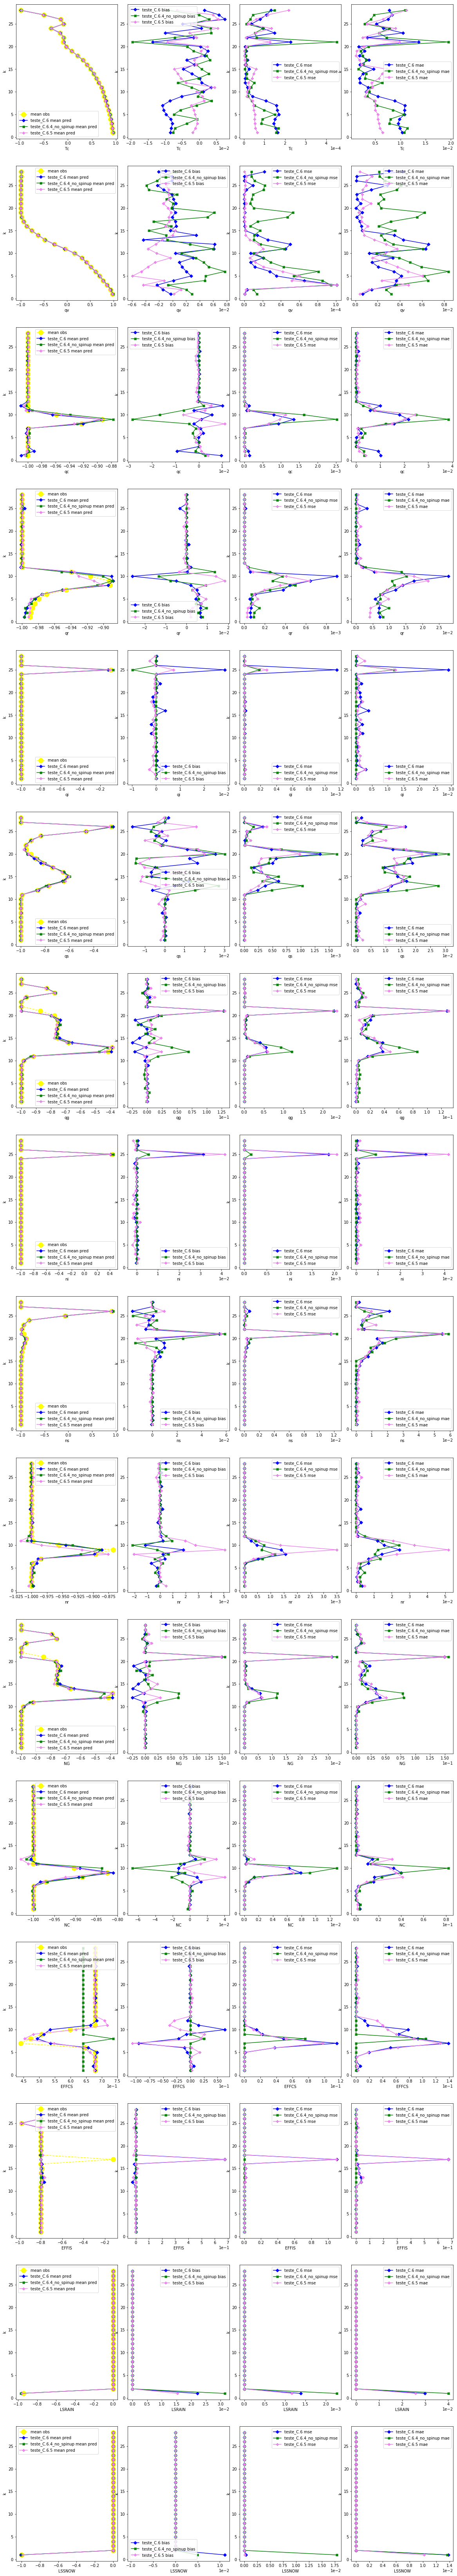

In [37]:
def generate_skill_graphic(skill, skill_fname, key, arr_test, arr_markers, arr_colors, plot_sci_numbers=True):
  for test, mark, color in zip(arr_test, arr_markers, arr_colors):
    path = '{}/{}/{}'.format(exp1_dir, test, skill_fname)  
    df_skill = pd.read_csv(path)
    skill_values = df_skill[key].values
    plt.plot(skill_values, range(1, len(skill_values)+1), label=test + ' ' + skill, marker=mark, color=color)
  if plot_sci_numbers:
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
  plt.legend()


def generate_subplot(ncols, nskills, idx_plot, key):
  plt.subplot(ncols, nskills, idx_plot)
  plt.ylabel("k")
  plt.xlabel(key)


def generate_all_graphics(arr_test, cols, obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors, plot_sci_numbers=True):
  idx_plot = 1
  plt.figure(figsize=(20, 120))
  for key in cols:
      if key == 'Unnamed: 0': 
        continue
      generate_subplot(len(cols)-1, len(arr_skills)+1, idx_plot, key)

      mean_obs_path = '{}/{}/{}'.format(exp1_dir, arr_test[0], obs_file_name)
      df_mean_obs = pd.read_csv(mean_obs_path)
      obs_values = df_mean_obs[key].values
      plt.plot(obs_values, range(1, len(obs_values)+1), label='mean obs',  marker='o', linestyle='dashed', color='yellow', markersize=12)
      
      generate_skill_graphic('mean pred', pred_file_name, key, arr_test, arr_markers, arr_colors, plot_sci_numbers)
      idx_plot += 1

      for skill, skill_fname in zip(arr_skills, arr_skill_filenames):
        generate_subplot(len(cols)-1, len(arr_skills)+1, idx_plot, key)
        generate_skill_graphic(skill, skill_fname, key, arr_test, arr_markers, arr_colors, plot_sci_numbers)
        idx_plot += 1
  
  plt.subplots_adjust(hspace=0.2, wspace=0.1)
  plt.show()



# exp1_dir = '/content/drive/My Drive/Colab Notebooks/logs_models_rttmg_dt60'
exp1_dir = '/content/drive/My Drive/Colab Notebooks/logs'
exp1_dir = tb_logdir_base

arr_test = [ 'teste_C.6', 'teste_C.6.4_no_spinup', 'teste_C.6.5' ]
arr_markers = ['D', 'X', 'P', 's']
arr_colors = ['blue','green', 'violet', 'red']

# arr_test = [ 'teste_C.6']
# arr_markers = ['D']
# arr_colors = ['blue']


# arr_markers = ['D', 'X', 'P', 's']
# arr_colors = ['blue', 'green', 'red', 'violet']
dummy_path = '{}/{}/{}'.format(exp1_dir, 'teste_C.6.4', 'log_mean_obs.csv')
dummy_df = pd.read_csv(dummy_path)

arr_skills = ['bias', 'mse', 'mae']

obs_file_name = 'log_mean_obs.csv'
pred_file_name = 'log_mean_pred.csv'
arr_skill_filenames = ['log_bias.csv', 'log_mse.csv', 'log_mae.csv']
generate_all_graphics(arr_test, dummy_df.columns.to_list(), obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors)


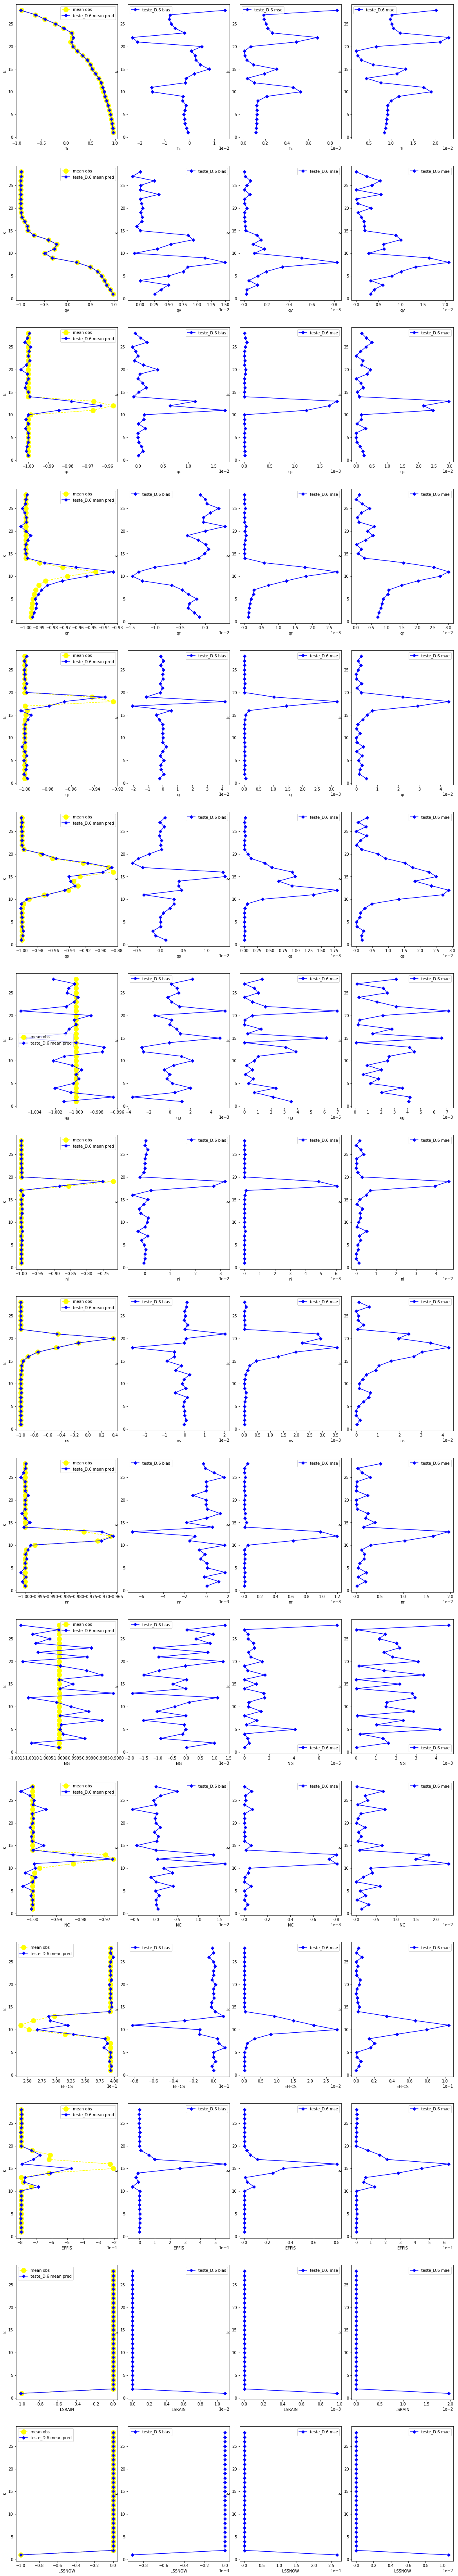

In [35]:
arr_test = [ 'teste_D.6']
arr_markers = ['D']
arr_colors = ['blue']
generate_all_graphics(arr_test, dummy_df.columns.to_list(), obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors)